##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

####  <font color=SlateBlue>Google Colab</font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####  <font color=SlateBlue>Reading Images</font>

In [ ]:
import os
from PIL import Image

####  <font color=SlateBlue>Preprocessing</font>

In [ ]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split as trainTestSplitter

####  <font color=SlateBlue>CNN</font> ####

In [ ]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

##  <font color=MediumSlateBlue>Classes and Functions</font> ##

####  <font color=SlateBlue>Loading Images and Transforming them</font> ####

In [ ]:
def readNamesFromFolder(imgLoc, labelLoc):
  """
  This function reads images and labels from the given location, and outputs the 
  names of them in a list to be used in various fucntions. 
  """
  imgNames = []
  labelNames = []

  for fileName in os.listdir(imgLoc):
    imgNames.append(os.path.join(imgLoc, fileName))
    labelNames.append(os.path.join(labelLoc, fileName.replace('.png', '_L.png')))

  return imgNames, labelNames

In [ ]:
def RGBtoIndex(img, indexRef):
  h, w = img.shape[-2], img.shape[-1]
  indxImg = torch.zeros(h, w, dtype=torch.long)
  
  for key in indexRef:
    idx = (img==torch.tensor(key, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
    validx = (idx.sum(0) == 3) 
    indxImg[validx] = torch.tensor(indexRef[key], dtype=torch.long)

  return indxImg

In [ ]:
def indextoRGB(img, clrRef):
  h, w = img.shape[-2], img.shape[-1] 
  newImg = np.zeros((3,h,w))

  for i in range(h):
    for j in range(w):
      classIndx = int(((img[i, j]).numpy()))
      r, g, b = clrRef[classIndx]
      newImg[0,i,j], newImg[1,i,j], newImg[2,i,j] = r, g, b

  return torch.tensor(newImg, dtype=torch.long)

In [ ]:
def transformer(img, transformMode, transformInfo):

  if transformMode == 'Image':
    transform = [T.ToTensor()]
    if 'Normalize' in transformInfo.keys():
      transform.append(T.Normalize(transformInfo['Normalize'][0], 
                                  transformInfo['Normalize'][1]))
    if 'CenterCrop' in transformInfo.keys():
      transform.append(T.CenterCrop((transformInfo['CenterCrop'][0],
                                    transformInfo['CenterCrop'][1])))
    trnsf = T.Compose(transform)
    img = trnsf(img)

  elif transformMode == 'Label':
    w, h = img.size
    
    newH = transformInfo['New Height']
    newW = transformInfo['New Width']

    top = (h - newH) * 0.5
    bottom = (h + newH) * 0.5

    left = (w - newW) * 0.5
    right = (w + newW) * 0.5

    img = img.crop((left, top, right, bottom))

    img = torch.tensor(np.array(img))
    img = img.permute(2, 0, 1).contiguous()
    img = RGBtoIndex(img, indexRef=classRef)

  return img

In [ ]:
class LoadCamVidDataset(Dataset):
  def __init__(self, dataNames, labelsNames, transformInfo, transforms=transformer): 
    """
    This class is used to load CamVid dataset. To do so, the location of the image
    and labels path are given as inputs. In addition, desired transformations can
    be employed on the input images and labels. To perform them, a dictionary is 
    passed with 'Image' and 'Label' keys. In each key, there is another dictionary 
    representing the deisred transformations to perform on the input images. 
    """
    self.dataNames = dataNames
    self.labelsNames = labelsNames

    self.transforms = transforms
    self.transformInfo = transformInfo

  def __getitem__(self, index):
    """
    With the given index, the desired image is opened and transfered to the 
    prefered shape. 
    """
    img = Image.open(self.dataNames[index])
    img = self.transforms(img, 'Image', transformInfo['Image'])
    
    label = Image.open(self.labelsNames[index])
    label = self.transforms(label, 'Label', transformInfo['Label'])
  
    return img, label

  def showImage(self, index=0):
    """
    By giving the desired index, the image with the same index is shown.
    """
    plt.imshow(Image.open(self.dataNames[index]))
    plt.title('True Image')
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
  def showLabel(self, index=0):
    """
    By giving the desired index, the label with the same index is shown.
    """
    plt.imshow(Image.open(self.labelsNames[index]))
    plt.title('Segmented Image')
    plt.xticks(())
    plt.yticks(())
    plt.show()

  def giveImgName(self, index=0): return self.dataNames[index]

  def giveLabelName(self, index=0): return self.labelsNames[index]

  def __len__(self): return len(self.dataNames)


In [ ]:
def showImgs(imgs, nmax, title):
  plt.subplots(figsize=(np.sqrt(nmax), np.sqrt(nmax)))
  plt.xticks(())
  plt.yticks(())
  plt.imshow(make_grid((imgs.detach()[:nmax]), nrow=np.sqrt(nmax)).permute(1, 2, 0))
  plt.title(title)
  plt.show()

def showImgBatch(batchDataset, title, nmax=400):
  for imgs, labels in batchDataset:
    showImgs(imgs, nmax, 'True Images ' + title)

    tensor = torch.ones((imgs.shape), dtype=torch.short)
    newLabels = [(indextoRGB(labels[i,:,:], RGBRef)).numpy() for i in range(imgs.shape[0])]
    showImgs(tensor.new_tensor(newLabels), nmax, 'Segmented Images ' + title)

    break
  

####  <font color=SlateBlue>CNN</font> ####

In [ ]:
class convBachNormReLU(nn.Module):
  def __init__(self, inChannels, outChannels, 
               kernelSize, strideSize=1, paddingSize=3, batchNormMomentum=0.9,
               biasCondition=True, batchNormCondition=True, ReLUCondition=True):
    super(convBachNormReLU, self).__init__()

    if batchNormCondition==True and ReLUCondition==True:
      self.unit = nn.Sequential(nn.Conv2d(in_channels=inChannels,
                                          out_channels=outChannels,
                                          kernel_size=kernelSize,
                                          stride=strideSize,
                                          padding=paddingSize,
                                          bias=biasCondition),
                                nn.BatchNorm2d(num_features=outChannels, 
                                               momentum=batchNormMomentum),
                                nn.ReLU(inplace=True))
      
    elif batchNormCondition==True and ReLUCondition==False:
      self.unit = nn.Sequential(nn.Conv2d(in_channels=inChannels,
                                          out_channels=outChannels,
                                          kernel_size=kernelSize,
                                          stride=strideSize,
                                          padding=paddingSize,
                                          bias=biasCondition),
                                nn.BatchNorm2d(num_features=outChannels, 
                                               momentum=batchNormMomentum))
      
    elif batchNormCondition==False and ReLUCondition==False:
      self.unit = nn.Sequential(nn.Conv2d(in_channels=inChannels,
                                          out_channels=outChannels,
                                          kernel_size=kernelSize,
                                          stride=strideSize,
                                          padding=paddingSize,
                                          bias=biasCondition))
      
    elif batchNormCondition==False and ReLUCondition==True:
      self.unit = nn.Sequential(nn.Conv2d(in_channels=inChannels,
                                          out_channels=outChannels,
                                          kernel_size=kernelSize,
                                          stride=strideSize,
                                          padding=paddingSize,
                                          bias=biasCondition),
                                nn.ReLU(inplace=True))
      

  def forward(self, input): return self.unit(input)

In [ ]:
class SegNet(nn.Module):
  def __init__(self, inChannels=3, outChannels=32, batchNormMomentum=0.9, 
               batchNormCondition=True):
    super(SegNet, self).__init__()
    
    self.encoder1 = convBachNormReLU(inChannels=inChannels, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=True)
    self.encoder2 = convBachNormReLU(inChannels=64, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=True)
    self.encoder3 = convBachNormReLU(inChannels=64, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=True)
    self.encoder4 = convBachNormReLU(inChannels=64, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=True)
    
    self.decoder4 = convBachNormReLU(inChannels=64, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=False)
    self.decoder3 = convBachNormReLU(inChannels=64, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=False)
    self.decoder2 = convBachNormReLU(inChannels=64, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=False)
    self.decoder1 = convBachNormReLU(inChannels=64, 
                                     outChannels=64, 
                                     kernelSize=7, 
                                     batchNormCondition=batchNormCondition, 
                                     ReLUCondition=False)
    
    self.maxPool1=nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.maxPool2=nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.maxPool3=nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.maxPool4=nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    self.maxUnpool4=nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.maxUnpool3=nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.maxUnpool2=nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.maxUnpool1=nn.MaxUnpool2d(kernel_size=2, stride=2)

    self.softMax = nn.Conv2d(in_channels=64,
                              out_channels=32,
                              kernel_size=7,
                              stride=1,
                              padding=3,
                              bias=True)

  def forward(self, input):

    outPoolEnc1, indicePoolEnc1 = self.maxPool1(self.encoder1(input))
    outPoolEnc2, indicePoolEnc2 = self.maxPool2(self.encoder2(outPoolEnc1))
    outPoolEnc3, indicePoolEnc3 = self.maxPool3(self.encoder3(outPoolEnc2))
    outPoolEnc4, indicePoolEnc4 = self.maxPool4(self.encoder4(outPoolEnc3))

    outDecUnpool4 = self.decoder4(self.maxUnpool4(outPoolEnc4, indicePoolEnc4))
    outDecUnpool4 = F.pad(outDecUnpool4, (0,0,1,0)) 
    outDecUnpool3 = self.decoder3(self.maxUnpool3(outDecUnpool4, indicePoolEnc3))
    outDecUnpool2 = self.decoder2(self.maxUnpool2(outDecUnpool3, indicePoolEnc2))
    outDecUnpool1 = self.decoder1(self.maxUnpool1(outDecUnpool2, indicePoolEnc1))

    return self.softMax(outDecUnpool1)


In [ ]:
def train(net, criterion, optimizer, batchTrainDataset, batchTestDataset, numEpochs):
  trainLoss, testLoss = [], []

  for numEpoch in range(numEpochs):
    print('Epoch %d has started......' %(numEpoch+1))

    trainDataLoss, testDataLoss = 0, 0 
    trainPrintFlag = 0

    print('Training the network......')
    net = net.train()

    for data, labels in batchTrainDataset:
      trainPrintFlag += 1

      if torch.cuda.is_available():
         data = Variable(data).cuda()
         labels = Variable(labels).cuda()
      else:
        data = Variable(data)
        labels = Variable(labels)

      allTrainPredLabels = net(data)
      loss = criterion(allTrainPredLabels, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      trainDataLoss += loss.item()

      if trainPrintFlag % 10 == 0: 
        print('Iteration:%d \t Loss:%1.5f' %(trainPrintFlag, trainDataLoss/trainPrintFlag))

    print('Testing the network......')
    net.eval()

    with torch.no_grad():
      for testData, testLabels in batchTestDataset:

        if torch.cuda.is_available():
         testData = Variable(testData).cuda()
         testLabels = Variable(testLabels).cuda()
        else:
          testData = Variable(testData)
          testLabels = Variable(testLabels)

        allTestPredLabels = net(testData)
        loss = criterion(allTestPredLabels, testLabels)
        testDataLoss += loss.item()

    print('At the end of epoch %d the average train loss is: %1.5f' %(numEpoch+1, trainDataLoss/len(batchTrainDataset)))
    trainLoss.append(trainDataLoss/len(batchTrainDataset))

    print('At the end of epoch %d the average test loss is: %1.5f' %(numEpoch+1, testDataLoss/len(batchTestDataset)))
    testLoss.append(testDataLoss/len(batchTestDataset))

    if (numEpoch%10==0) and (numEpoch>0):
      plt.plot(trainLoss, label='Train Loss', color='slateblue')
      plt.plot(testLoss, label='Test Loss', color='mediumpurple')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

    trainPredLabels = allTrainPredLabels.max(dim=1)[1].data.cpu()
    tensor = torch.ones((data.shape), dtype=torch.short)
    newLabels = (indextoRGB(trainPredLabels[0,:,:], RGBRef)).numpy()
    showImgs(tensor.new_tensor(newLabels), 25, 'Predicted Segmented Images')

    labels = labels.data.cpu()
    tensor = torch.ones((data.shape), dtype=torch.short)
    newLabels = (indextoRGB(labels[0,:,:], RGBRef)).numpy()
    showImgs(tensor.new_tensor(newLabels), 25, 'True Segmented Images')

  plt.plot(trainLoss, label='Train Loss', color='slateblue')
  plt.plot(testLoss, label='Test Loss', color='mediumpurple')
  plt.title('Loss vs. Epochs')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show()

  trainPredLabels = allTrainPredLabels.max(dim=1)[1].data.cpu()
  tensor = torch.ones((data.shape), dtype=torch.short)
  newLabels = [(indextoRGB(trainPredLabels[i,:,:], RGBRef)).numpy() for i in range(data.shape[0])]
  showImgs(tensor.new_tensor(newLabels), 25, 'Predicted Segmented Images')

  labels = labels.data.cpu()
  tensor = torch.ones((data.shape), dtype=torch.short)
  newLabels = [(indextoRGB(labels[i,:,:], RGBRef)).numpy() for i in range(data.shape[0])]
  showImgs(tensor.new_tensor(newLabels), 25, 'True Segmented Images')

  


##  <font color=MediumSlateBlue>Loading Data and Storing</font> ##

####  <font color=SlateBlue>Reading Class' Names and Colors and Storing Them</font> ####

In [ ]:
classNamesLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/label_colors.txt'

with open(classNamesLoc, 'r') as f:
    lines = f.readlines()

data = [lines[i].split() for i in range(len(lines))]

In [ ]:
RGBcodes = [tuple(map(int, data[i][0:3])) for i in range(len(data))]

classRef = {RGBcodes[i]:i for i in range(len(data))}
RGBRef = {i:RGBcodes[i] for i in range(len(data))}

####  <font color=SlateBlue>Reading Images and Labels and Splitting Them</font> ####

In [ ]:
camVidImgsLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/Data' #direction of CamVid images
labelsLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/Labels' #direction of Segmented images (labels)

In [ ]:
imgsNames, labelsNames = readNamesFromFolder(camVidImgsLoc, labelsLoc)

In [ ]:
trainDataNames, testDataNames, trainLabelsNames, testLabelsNames = trainTestSplitter(imgsNames, 
                                                                                     labelsNames, 
                                                                                     test_size=0.2, 
                                                                                     random_state=42)

####  <font color=SlateBlue>Transforming Datasets and Creating Batches</font> ####

In [ ]:
transformInfo = {'Image':{'Normalize':[[0.485, 0.456, 0.406], 
                                       [0.229, 0.224, 0.225]],
                          'CenterCrop':[360, 480]},
                 'Label':{'New Height':360, 'New Width':480}
                 }
myTrainDataLoader = LoadCamVidDataset(trainDataNames, 
                                      trainLabelsNames, 
                                      transformInfo=transformInfo, 
                                      transforms=transformer)

In [ ]:
batchTrainDataset = DataLoader(myTrainDataLoader, batch_size=4, 
                               shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


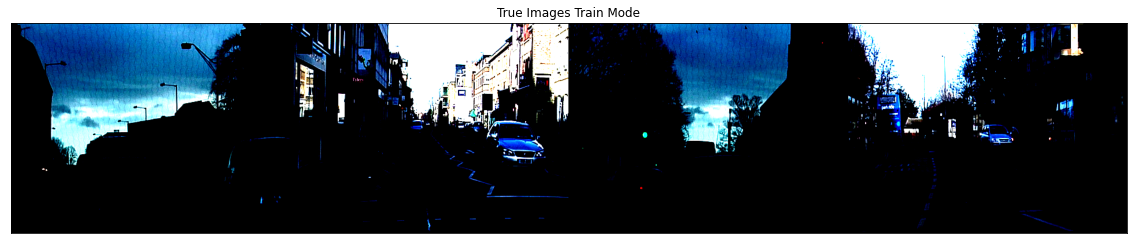

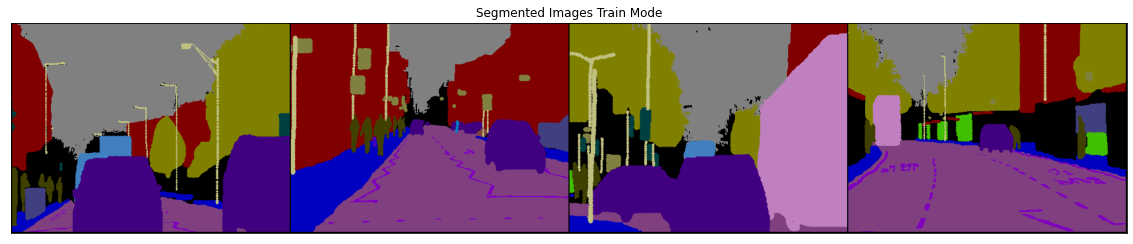

In [ ]:
showImgBatch(batchTrainDataset, 'Train Mode')

In [ ]:
transformInfo = {'Image':{'Normalize':[[0.485, 0.456, 0.406], 
                                       [0.229, 0.224, 0.225]],
                          'CenterCrop':[360, 480]},
                 'Label':{'New Height':360, 'New Width':480}
                 }
myTestDataLoader = LoadCamVidDataset(testDataNames, 
                                      testLabelsNames, 
                                      transformInfo=transformInfo, 
                                      transforms=transformer)

In [ ]:
batchTestDataset = DataLoader(myTestDataLoader, batch_size=4, 
                               shuffle=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


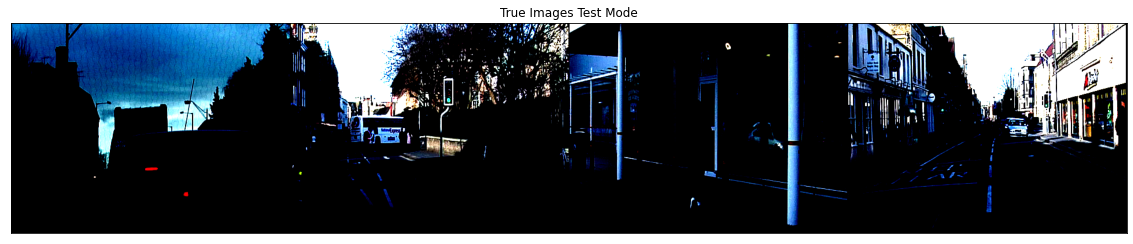

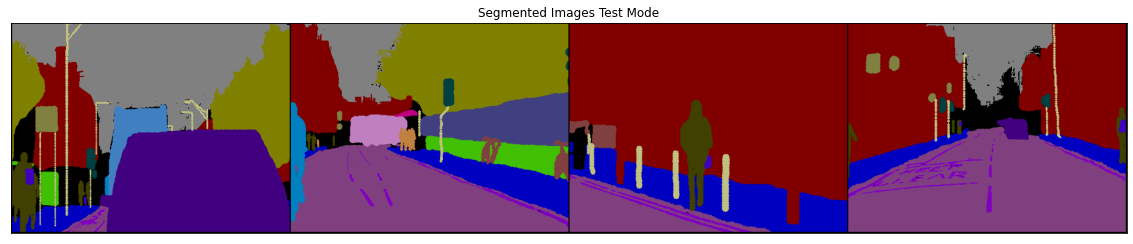

In [ ]:
showImgBatch(batchTestDataset, 'Test Mode')

##  <font color=MediumSlateBlue>Trainning and Plotting Required Plots without Batch Normalization</font> ##

In [ ]:
mySegNet = SegNet(3, 32, batchNormCondition=False)

if torch.cuda.is_available():
     mySegNet = mySegNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mySegNet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

####  <font color=SlateBlue>Trainning the Network</font> ####

Epoch 1 has started......
Training the network......
Iteration:10 	 Loss:3.04970
Iteration:20 	 Loss:2.98063
Iteration:30 	 Loss:2.90497
Iteration:40 	 Loss:2.83691
Iteration:50 	 Loss:2.78454
Iteration:60 	 Loss:2.73603
Iteration:70 	 Loss:2.70228
Iteration:80 	 Loss:2.66926
Iteration:90 	 Loss:2.63779
Iteration:100 	 Loss:2.60809
Iteration:110 	 Loss:2.58734
Iteration:120 	 Loss:2.56566
Iteration:130 	 Loss:2.54635
Iteration:140 	 Loss:2.52943
Testing the network......
At the end of epoch 1 the average train loss is: 2.52943
At the end of epoch 1 the average test loss is: 2.38436


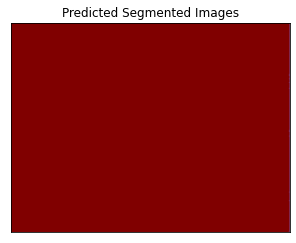

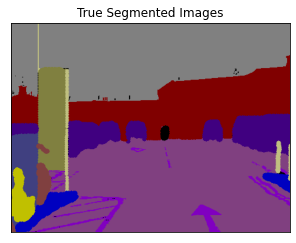

Epoch 2 has started......
Training the network......
Iteration:10 	 Loss:2.32086
Iteration:20 	 Loss:2.32276
Iteration:30 	 Loss:2.34099
Iteration:40 	 Loss:2.34866
Iteration:50 	 Loss:2.34840
Iteration:60 	 Loss:2.34026
Iteration:70 	 Loss:2.33847
Iteration:80 	 Loss:2.32844
Iteration:90 	 Loss:2.31850
Iteration:100 	 Loss:2.32979
Iteration:110 	 Loss:2.33023
Iteration:120 	 Loss:2.33125
Iteration:130 	 Loss:2.33096
Iteration:140 	 Loss:2.33318
Testing the network......
At the end of epoch 2 the average train loss is: 2.33318
At the end of epoch 2 the average test loss is: 2.35131


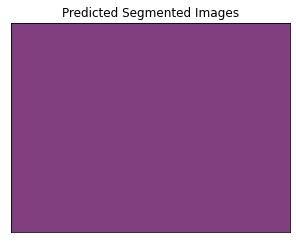

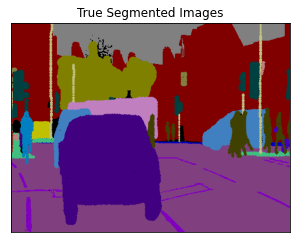

Epoch 3 has started......
Training the network......
Iteration:10 	 Loss:2.27956
Iteration:20 	 Loss:2.29568
Iteration:30 	 Loss:2.28600
Iteration:40 	 Loss:2.29747
Iteration:50 	 Loss:2.29282
Iteration:60 	 Loss:2.30629
Iteration:70 	 Loss:2.30512
Iteration:80 	 Loss:2.30123
Iteration:90 	 Loss:2.30179
Iteration:100 	 Loss:2.30940
Iteration:110 	 Loss:2.31604
Iteration:120 	 Loss:2.31920
Iteration:130 	 Loss:2.31556
Iteration:140 	 Loss:2.31630
Testing the network......
At the end of epoch 3 the average train loss is: 2.31630
At the end of epoch 3 the average test loss is: 2.34300


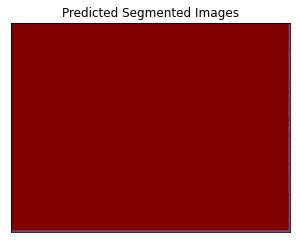

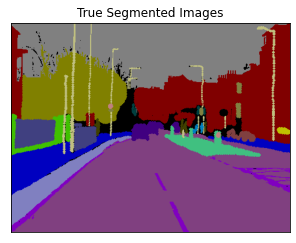

Epoch 4 has started......
Training the network......
Iteration:10 	 Loss:2.34926
Iteration:20 	 Loss:2.32191
Iteration:30 	 Loss:2.29491
Iteration:40 	 Loss:2.30706
Iteration:50 	 Loss:2.31051
Iteration:60 	 Loss:2.31683
Iteration:70 	 Loss:2.32298
Iteration:80 	 Loss:2.31954
Iteration:90 	 Loss:2.31115
Iteration:100 	 Loss:2.30238
Iteration:110 	 Loss:2.30869
Iteration:120 	 Loss:2.31155
Iteration:130 	 Loss:2.30814
Iteration:140 	 Loss:2.30962
Testing the network......
At the end of epoch 4 the average train loss is: 2.30962
At the end of epoch 4 the average test loss is: 2.33265


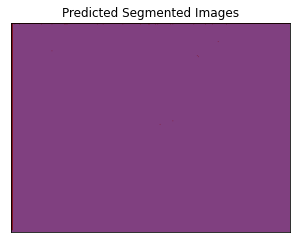

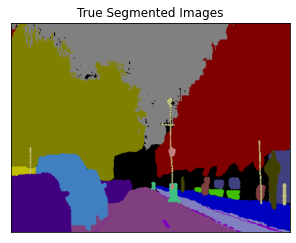

Epoch 5 has started......
Training the network......
Iteration:10 	 Loss:2.32836
Iteration:20 	 Loss:2.29085
Iteration:30 	 Loss:2.30028
Iteration:40 	 Loss:2.27411
Iteration:50 	 Loss:2.27606
Iteration:60 	 Loss:2.27693
Iteration:70 	 Loss:2.28571
Iteration:80 	 Loss:2.29722
Iteration:90 	 Loss:2.29341
Iteration:100 	 Loss:2.29297
Iteration:110 	 Loss:2.29466
Iteration:120 	 Loss:2.29597
Iteration:130 	 Loss:2.30152
Iteration:140 	 Loss:2.30402
Testing the network......
At the end of epoch 5 the average train loss is: 2.30402
At the end of epoch 5 the average test loss is: 2.32450


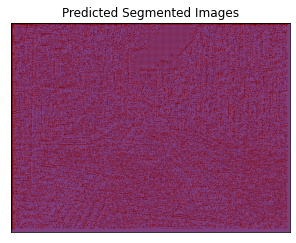

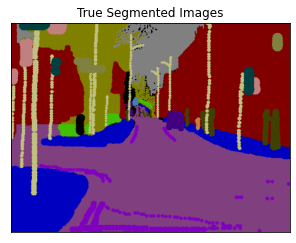

Epoch 6 has started......
Training the network......
Iteration:10 	 Loss:2.36241
Iteration:20 	 Loss:2.34761
Iteration:30 	 Loss:2.32816
Iteration:40 	 Loss:2.31699
Iteration:50 	 Loss:2.30739
Iteration:60 	 Loss:2.32173
Iteration:70 	 Loss:2.30912
Iteration:80 	 Loss:2.30660
Iteration:90 	 Loss:2.30336
Iteration:100 	 Loss:2.30196
Iteration:110 	 Loss:2.30531
Iteration:120 	 Loss:2.30702
Iteration:130 	 Loss:2.30079
Iteration:140 	 Loss:2.30006
Testing the network......
At the end of epoch 6 the average train loss is: 2.30006
At the end of epoch 6 the average test loss is: 2.33320


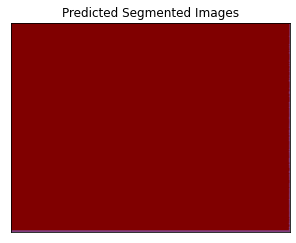

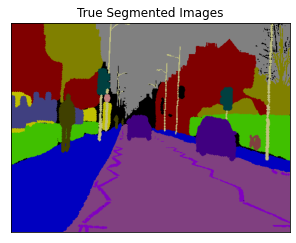

Epoch 7 has started......
Training the network......
Iteration:10 	 Loss:2.31532
Iteration:20 	 Loss:2.30527
Iteration:30 	 Loss:2.31393
Iteration:40 	 Loss:2.30843
Iteration:50 	 Loss:2.31217
Iteration:60 	 Loss:2.30251
Iteration:70 	 Loss:2.30047
Iteration:80 	 Loss:2.29941
Iteration:90 	 Loss:2.29280
Iteration:100 	 Loss:2.29621
Iteration:110 	 Loss:2.29714
Iteration:120 	 Loss:2.29710
Iteration:130 	 Loss:2.29524
Iteration:140 	 Loss:2.29821
Testing the network......
At the end of epoch 7 the average train loss is: 2.29821
At the end of epoch 7 the average test loss is: 2.31715


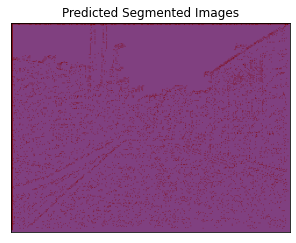

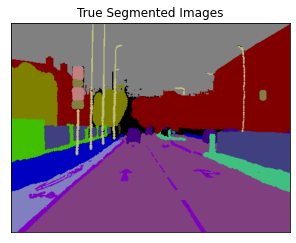

Epoch 8 has started......
Training the network......
Iteration:10 	 Loss:2.27347
Iteration:20 	 Loss:2.27405
Iteration:30 	 Loss:2.27330
Iteration:40 	 Loss:2.27203
Iteration:50 	 Loss:2.26489
Iteration:60 	 Loss:2.26731
Iteration:70 	 Loss:2.27503
Iteration:80 	 Loss:2.27715
Iteration:90 	 Loss:2.28550
Iteration:100 	 Loss:2.28618
Iteration:110 	 Loss:2.28595
Iteration:120 	 Loss:2.28836
Iteration:130 	 Loss:2.29007
Iteration:140 	 Loss:2.29597
Testing the network......
At the end of epoch 8 the average train loss is: 2.29597
At the end of epoch 8 the average test loss is: 2.30512


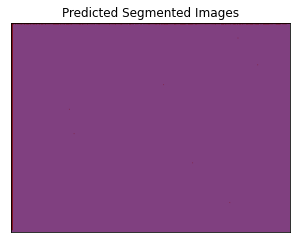

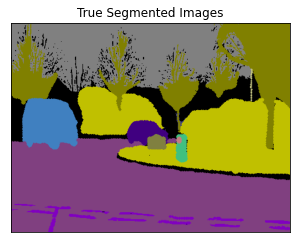

Epoch 9 has started......
Training the network......
Iteration:10 	 Loss:2.31726
Iteration:20 	 Loss:2.33589
Iteration:30 	 Loss:2.32278
Iteration:40 	 Loss:2.30749
Iteration:50 	 Loss:2.31355
Iteration:60 	 Loss:2.30115
Iteration:70 	 Loss:2.30019
Iteration:80 	 Loss:2.30360
Iteration:90 	 Loss:2.29515
Iteration:100 	 Loss:2.29683
Iteration:110 	 Loss:2.29703
Iteration:120 	 Loss:2.29502
Iteration:130 	 Loss:2.29393
Iteration:140 	 Loss:2.29562
Testing the network......
At the end of epoch 9 the average train loss is: 2.29562
At the end of epoch 9 the average test loss is: 2.32074


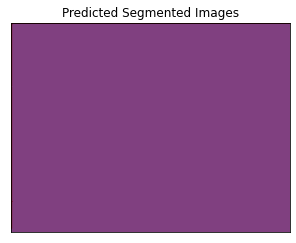

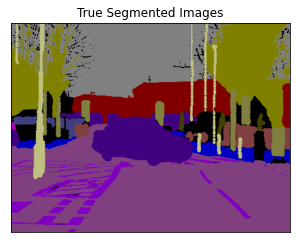

Epoch 10 has started......
Training the network......
Iteration:10 	 Loss:2.23234
Iteration:20 	 Loss:2.24136
Iteration:30 	 Loss:2.25548
Iteration:40 	 Loss:2.26295
Iteration:50 	 Loss:2.27018
Iteration:60 	 Loss:2.28616
Iteration:70 	 Loss:2.28553
Iteration:80 	 Loss:2.29044
Iteration:90 	 Loss:2.28771
Iteration:100 	 Loss:2.28938
Iteration:110 	 Loss:2.29012
Iteration:120 	 Loss:2.28787
Iteration:130 	 Loss:2.28995
Iteration:140 	 Loss:2.29413
Testing the network......
At the end of epoch 10 the average train loss is: 2.29413
At the end of epoch 10 the average test loss is: 2.32106


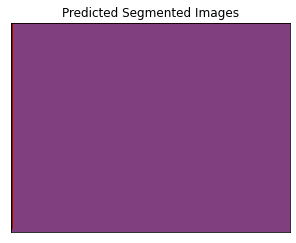

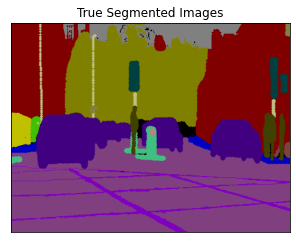

Epoch 11 has started......
Training the network......
Iteration:10 	 Loss:2.34190
Iteration:20 	 Loss:2.29444
Iteration:30 	 Loss:2.28645
Iteration:40 	 Loss:2.29700
Iteration:50 	 Loss:2.29731
Iteration:60 	 Loss:2.29844
Iteration:70 	 Loss:2.28869
Iteration:80 	 Loss:2.28931
Iteration:90 	 Loss:2.28853
Iteration:100 	 Loss:2.28617
Iteration:110 	 Loss:2.28470
Iteration:120 	 Loss:2.28863
Iteration:130 	 Loss:2.29044
Iteration:140 	 Loss:2.29325
Testing the network......
At the end of epoch 11 the average train loss is: 2.29325
At the end of epoch 11 the average test loss is: 2.31175


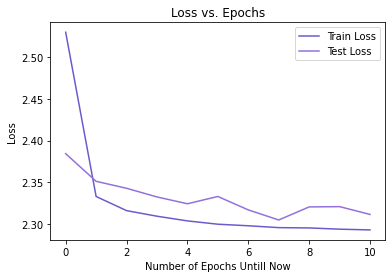

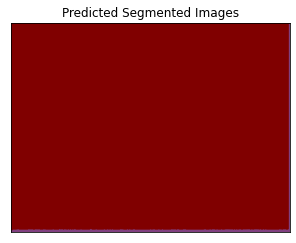

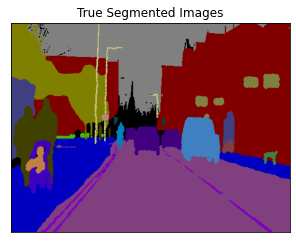

Epoch 12 has started......
Training the network......
Iteration:10 	 Loss:2.30756
Iteration:20 	 Loss:2.34505
Iteration:30 	 Loss:2.32217
Iteration:40 	 Loss:2.31956
Iteration:50 	 Loss:2.31937
Iteration:60 	 Loss:2.31113
Iteration:70 	 Loss:2.31155
Iteration:80 	 Loss:2.31198
Iteration:90 	 Loss:2.30586
Iteration:100 	 Loss:2.30564
Iteration:110 	 Loss:2.29585
Iteration:120 	 Loss:2.29544
Iteration:130 	 Loss:2.29477
Iteration:140 	 Loss:2.29142
Testing the network......
At the end of epoch 12 the average train loss is: 2.29142
At the end of epoch 12 the average test loss is: 2.31570


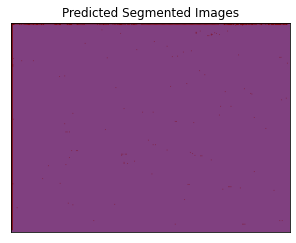

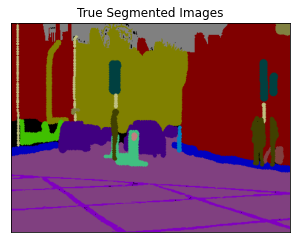

Epoch 13 has started......
Training the network......
Iteration:10 	 Loss:2.28058
Iteration:20 	 Loss:2.29406
Iteration:30 	 Loss:2.29369
Iteration:40 	 Loss:2.29933
Iteration:50 	 Loss:2.29700
Iteration:60 	 Loss:2.30584
Iteration:70 	 Loss:2.30659
Iteration:80 	 Loss:2.29338
Iteration:90 	 Loss:2.29976
Iteration:100 	 Loss:2.29429
Iteration:110 	 Loss:2.29470
Iteration:120 	 Loss:2.29126
Iteration:130 	 Loss:2.28891
Iteration:140 	 Loss:2.29016
Testing the network......
At the end of epoch 13 the average train loss is: 2.29016
At the end of epoch 13 the average test loss is: 2.31349


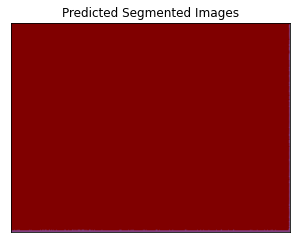

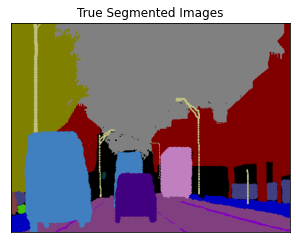

Epoch 14 has started......
Training the network......
Iteration:10 	 Loss:2.30203
Iteration:20 	 Loss:2.32709
Iteration:30 	 Loss:2.31409
Iteration:40 	 Loss:2.31500
Iteration:50 	 Loss:2.30989
Iteration:60 	 Loss:2.30593
Iteration:70 	 Loss:2.30561
Iteration:80 	 Loss:2.30218
Iteration:90 	 Loss:2.30475
Iteration:100 	 Loss:2.29993
Iteration:110 	 Loss:2.29549
Iteration:120 	 Loss:2.29800
Iteration:130 	 Loss:2.29129
Iteration:140 	 Loss:2.28937
Testing the network......
At the end of epoch 14 the average train loss is: 2.28937
At the end of epoch 14 the average test loss is: 2.31321


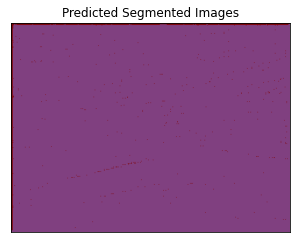

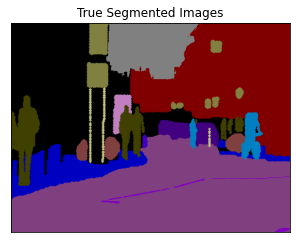

Epoch 15 has started......
Training the network......
Iteration:10 	 Loss:2.23719
Iteration:20 	 Loss:2.23065
Iteration:30 	 Loss:2.26366
Iteration:40 	 Loss:2.28119
Iteration:50 	 Loss:2.28315
Iteration:60 	 Loss:2.28464
Iteration:70 	 Loss:2.29172
Iteration:80 	 Loss:2.28511
Iteration:90 	 Loss:2.28886
Iteration:100 	 Loss:2.28984
Iteration:110 	 Loss:2.28779
Iteration:120 	 Loss:2.28773
Iteration:130 	 Loss:2.28783
Iteration:140 	 Loss:2.28942
Testing the network......
At the end of epoch 15 the average train loss is: 2.28942
At the end of epoch 15 the average test loss is: 2.30755


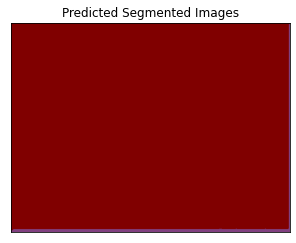

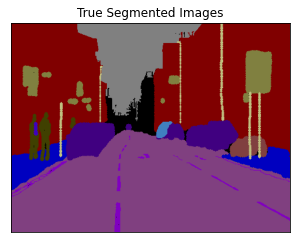

Epoch 16 has started......
Training the network......
Iteration:10 	 Loss:2.25595
Iteration:20 	 Loss:2.28271
Iteration:30 	 Loss:2.30534
Iteration:40 	 Loss:2.28831
Iteration:50 	 Loss:2.29390
Iteration:60 	 Loss:2.29386
Iteration:70 	 Loss:2.28378
Iteration:80 	 Loss:2.28869
Iteration:90 	 Loss:2.28894
Iteration:100 	 Loss:2.29353
Iteration:110 	 Loss:2.29489
Iteration:120 	 Loss:2.29254
Iteration:130 	 Loss:2.28866
Iteration:140 	 Loss:2.28939
Testing the network......
At the end of epoch 16 the average train loss is: 2.28939
At the end of epoch 16 the average test loss is: 2.32380


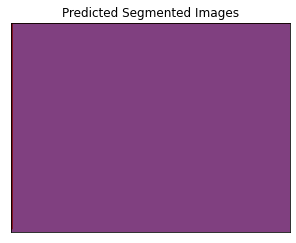

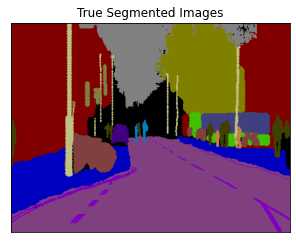

Epoch 17 has started......
Training the network......
Iteration:10 	 Loss:2.24759
Iteration:20 	 Loss:2.28669
Iteration:30 	 Loss:2.26252
Iteration:40 	 Loss:2.27036
Iteration:50 	 Loss:2.26533
Iteration:60 	 Loss:2.26496
Iteration:70 	 Loss:2.26880
Iteration:80 	 Loss:2.27971
Iteration:90 	 Loss:2.27995
Iteration:100 	 Loss:2.28115
Iteration:110 	 Loss:2.28463
Iteration:120 	 Loss:2.29167
Iteration:130 	 Loss:2.29084
Iteration:140 	 Loss:2.28848
Testing the network......
At the end of epoch 17 the average train loss is: 2.28848
At the end of epoch 17 the average test loss is: 2.31087


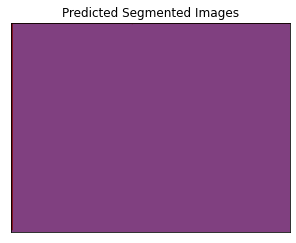

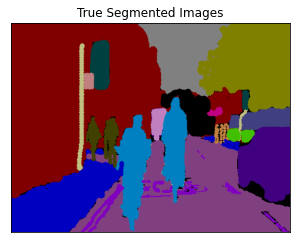

Epoch 18 has started......
Training the network......
Iteration:10 	 Loss:2.33026
Iteration:20 	 Loss:2.32314
Iteration:30 	 Loss:2.30426
Iteration:40 	 Loss:2.28955
Iteration:50 	 Loss:2.28220
Iteration:60 	 Loss:2.27505
Iteration:70 	 Loss:2.26844
Iteration:80 	 Loss:2.27510
Iteration:90 	 Loss:2.27929
Iteration:100 	 Loss:2.27729
Iteration:110 	 Loss:2.28649
Iteration:120 	 Loss:2.28454
Iteration:130 	 Loss:2.28550
Iteration:140 	 Loss:2.28920
Testing the network......
At the end of epoch 18 the average train loss is: 2.28920
At the end of epoch 18 the average test loss is: 2.30666


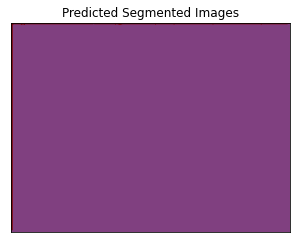

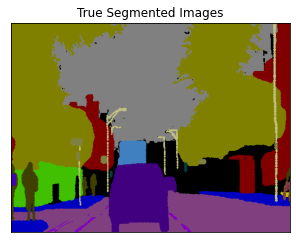

Epoch 19 has started......
Training the network......
Iteration:10 	 Loss:2.25810
Iteration:20 	 Loss:2.22955
Iteration:30 	 Loss:2.28125
Iteration:40 	 Loss:2.27881
Iteration:50 	 Loss:2.28174
Iteration:60 	 Loss:2.28032
Iteration:70 	 Loss:2.27949
Iteration:80 	 Loss:2.28657
Iteration:90 	 Loss:2.28806
Iteration:100 	 Loss:2.28368
Iteration:110 	 Loss:2.27858
Iteration:120 	 Loss:2.28249
Iteration:130 	 Loss:2.28876
Iteration:140 	 Loss:2.28891
Testing the network......
At the end of epoch 19 the average train loss is: 2.28891
At the end of epoch 19 the average test loss is: 2.30571


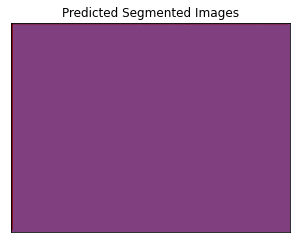

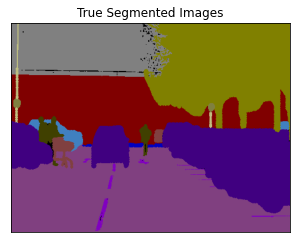

Epoch 20 has started......
Training the network......
Iteration:10 	 Loss:2.33747
Iteration:20 	 Loss:2.32445
Iteration:30 	 Loss:2.29316
Iteration:40 	 Loss:2.29259
Iteration:50 	 Loss:2.28698
Iteration:60 	 Loss:2.27839
Iteration:70 	 Loss:2.27591
Iteration:80 	 Loss:2.27546
Iteration:90 	 Loss:2.27906
Iteration:100 	 Loss:2.28102
Iteration:110 	 Loss:2.27889
Iteration:120 	 Loss:2.28076
Iteration:130 	 Loss:2.28497
Iteration:140 	 Loss:2.28686
Testing the network......
At the end of epoch 20 the average train loss is: 2.28686
At the end of epoch 20 the average test loss is: 2.30533


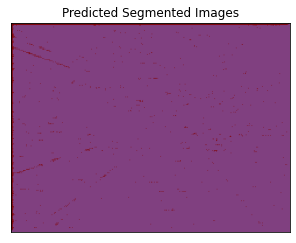

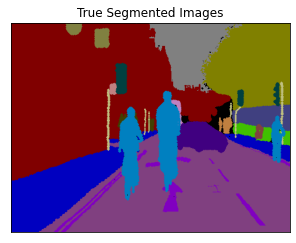

Epoch 21 has started......
Training the network......
Iteration:10 	 Loss:2.33106
Iteration:20 	 Loss:2.31469
Iteration:30 	 Loss:2.29735
Iteration:40 	 Loss:2.28869
Iteration:50 	 Loss:2.28720
Iteration:60 	 Loss:2.28683
Iteration:70 	 Loss:2.28650
Iteration:80 	 Loss:2.28785
Iteration:90 	 Loss:2.28842
Iteration:100 	 Loss:2.28460
Iteration:110 	 Loss:2.28509
Iteration:120 	 Loss:2.28375
Iteration:130 	 Loss:2.28649
Iteration:140 	 Loss:2.28601
Testing the network......
At the end of epoch 21 the average train loss is: 2.28601
At the end of epoch 21 the average test loss is: 2.31309


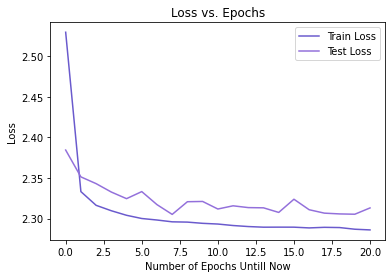

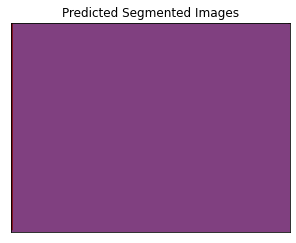

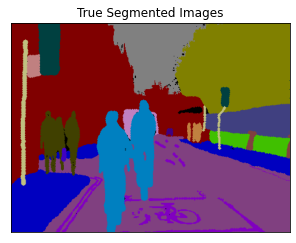

Epoch 22 has started......
Training the network......
Iteration:10 	 Loss:2.27460
Iteration:20 	 Loss:2.28606
Iteration:30 	 Loss:2.29434
Iteration:40 	 Loss:2.30037
Iteration:50 	 Loss:2.29336
Iteration:60 	 Loss:2.28472
Iteration:70 	 Loss:2.27259
Iteration:80 	 Loss:2.28302
Iteration:90 	 Loss:2.28286
Iteration:100 	 Loss:2.28072
Iteration:110 	 Loss:2.28209
Iteration:120 	 Loss:2.28937
Iteration:130 	 Loss:2.29265
Iteration:140 	 Loss:2.28670
Testing the network......
At the end of epoch 22 the average train loss is: 2.28670
At the end of epoch 22 the average test loss is: 2.31017


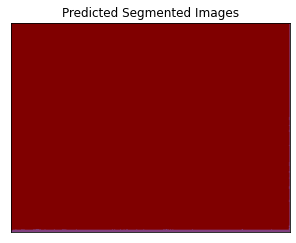

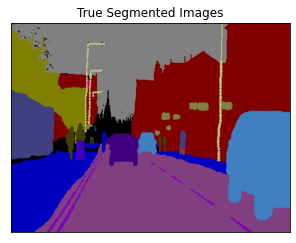

Epoch 23 has started......
Training the network......
Iteration:10 	 Loss:2.20366
Iteration:20 	 Loss:2.21702
Iteration:30 	 Loss:2.25979
Iteration:40 	 Loss:2.25971
Iteration:50 	 Loss:2.26117
Iteration:60 	 Loss:2.26780
Iteration:70 	 Loss:2.27204
Iteration:80 	 Loss:2.27705
Iteration:90 	 Loss:2.27739
Iteration:100 	 Loss:2.27844
Iteration:110 	 Loss:2.27695
Iteration:120 	 Loss:2.28229
Iteration:130 	 Loss:2.27977
Iteration:140 	 Loss:2.28597
Testing the network......
At the end of epoch 23 the average train loss is: 2.28597
At the end of epoch 23 the average test loss is: 2.30686


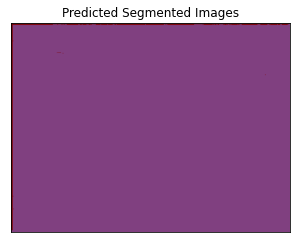

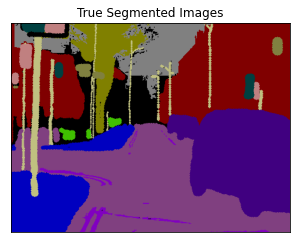

Epoch 24 has started......
Training the network......
Iteration:10 	 Loss:2.31550
Iteration:20 	 Loss:2.26839
Iteration:30 	 Loss:2.28373
Iteration:40 	 Loss:2.29294
Iteration:50 	 Loss:2.28874
Iteration:60 	 Loss:2.29058
Iteration:70 	 Loss:2.29232
Iteration:80 	 Loss:2.28679
Iteration:90 	 Loss:2.28566
Iteration:100 	 Loss:2.28365
Iteration:110 	 Loss:2.28768
Iteration:120 	 Loss:2.28579
Iteration:130 	 Loss:2.28830
Iteration:140 	 Loss:2.28602
Testing the network......
At the end of epoch 24 the average train loss is: 2.28602
At the end of epoch 24 the average test loss is: 2.30380


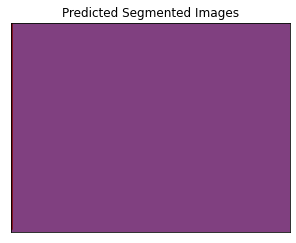

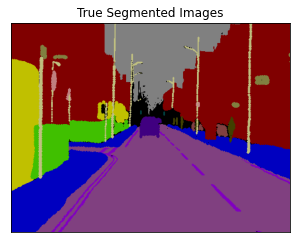

Epoch 25 has started......
Training the network......
Iteration:10 	 Loss:2.32984
Iteration:20 	 Loss:2.29596
Iteration:30 	 Loss:2.29005
Iteration:40 	 Loss:2.28324
Iteration:50 	 Loss:2.28583
Iteration:60 	 Loss:2.29351
Iteration:70 	 Loss:2.28380
Iteration:80 	 Loss:2.27787
Iteration:90 	 Loss:2.27716
Iteration:100 	 Loss:2.27345
Iteration:110 	 Loss:2.28144
Iteration:120 	 Loss:2.28068
Iteration:130 	 Loss:2.28634
Iteration:140 	 Loss:2.28516
Testing the network......
At the end of epoch 25 the average train loss is: 2.28516
At the end of epoch 25 the average test loss is: 2.32515


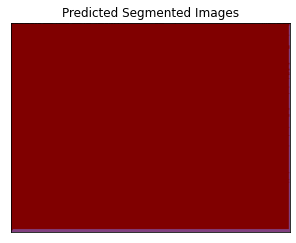

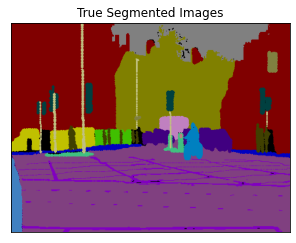

Epoch 26 has started......
Training the network......
Iteration:10 	 Loss:2.23272
Iteration:20 	 Loss:2.27698
Iteration:30 	 Loss:2.27811
Iteration:40 	 Loss:2.26901
Iteration:50 	 Loss:2.28060
Iteration:60 	 Loss:2.27771
Iteration:70 	 Loss:2.26866
Iteration:80 	 Loss:2.27526
Iteration:90 	 Loss:2.27515
Iteration:100 	 Loss:2.27391
Iteration:110 	 Loss:2.28165
Iteration:120 	 Loss:2.28057
Iteration:130 	 Loss:2.28275
Iteration:140 	 Loss:2.28418
Testing the network......
At the end of epoch 26 the average train loss is: 2.28418
At the end of epoch 26 the average test loss is: 2.30320


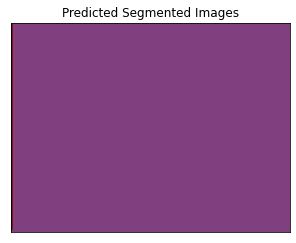

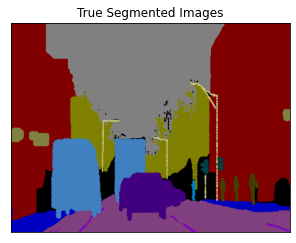

Epoch 27 has started......
Training the network......
Iteration:10 	 Loss:2.28990
Iteration:20 	 Loss:2.33262
Iteration:30 	 Loss:2.33715
Iteration:40 	 Loss:2.32045
Iteration:50 	 Loss:2.30707
Iteration:60 	 Loss:2.28685
Iteration:70 	 Loss:2.28502
Iteration:80 	 Loss:2.28765
Iteration:90 	 Loss:2.28680
Iteration:100 	 Loss:2.28734
Iteration:110 	 Loss:2.27906
Iteration:120 	 Loss:2.28251
Iteration:130 	 Loss:2.28500
Iteration:140 	 Loss:2.28501
Testing the network......
At the end of epoch 27 the average train loss is: 2.28501
At the end of epoch 27 the average test loss is: 2.30711


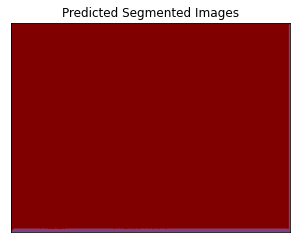

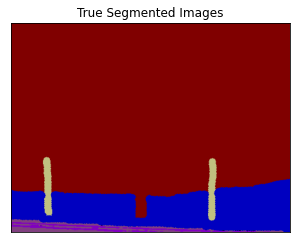

Epoch 28 has started......
Training the network......
Iteration:10 	 Loss:2.30767
Iteration:20 	 Loss:2.28395
Iteration:30 	 Loss:2.28991
Iteration:40 	 Loss:2.29073
Iteration:50 	 Loss:2.29220
Iteration:60 	 Loss:2.29085
Iteration:70 	 Loss:2.28736
Iteration:80 	 Loss:2.28283
Iteration:90 	 Loss:2.28438
Iteration:100 	 Loss:2.28803
Iteration:110 	 Loss:2.28263
Iteration:120 	 Loss:2.28704
Iteration:130 	 Loss:2.28684
Iteration:140 	 Loss:2.28483
Testing the network......
At the end of epoch 28 the average train loss is: 2.28483
At the end of epoch 28 the average test loss is: 2.29602


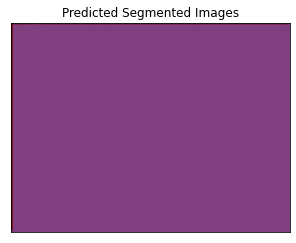

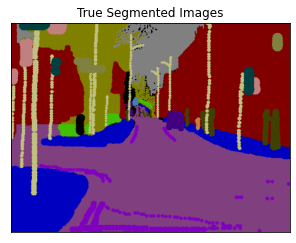

Epoch 29 has started......
Training the network......
Iteration:10 	 Loss:2.32459
Iteration:20 	 Loss:2.29667
Iteration:30 	 Loss:2.27906
Iteration:40 	 Loss:2.28025
Iteration:50 	 Loss:2.28141
Iteration:60 	 Loss:2.27759
Iteration:70 	 Loss:2.28042
Iteration:80 	 Loss:2.27749
Iteration:90 	 Loss:2.27088
Iteration:100 	 Loss:2.27634
Iteration:110 	 Loss:2.28005
Iteration:120 	 Loss:2.28120
Iteration:130 	 Loss:2.28018
Iteration:140 	 Loss:2.28535
Testing the network......
At the end of epoch 29 the average train loss is: 2.28535
At the end of epoch 29 the average test loss is: 2.32633


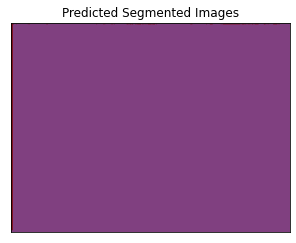

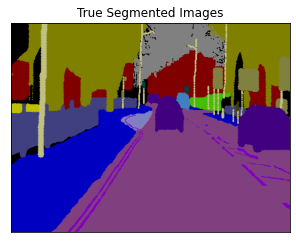

Epoch 30 has started......
Training the network......
Iteration:10 	 Loss:2.30516
Iteration:20 	 Loss:2.27906
Iteration:30 	 Loss:2.29133
Iteration:40 	 Loss:2.28430
Iteration:50 	 Loss:2.28534
Iteration:60 	 Loss:2.28482
Iteration:70 	 Loss:2.28010
Iteration:80 	 Loss:2.27970
Iteration:90 	 Loss:2.27677
Iteration:100 	 Loss:2.28059
Iteration:110 	 Loss:2.28664
Iteration:120 	 Loss:2.28621
Iteration:130 	 Loss:2.28415
Iteration:140 	 Loss:2.28363
Testing the network......
At the end of epoch 30 the average train loss is: 2.28363
At the end of epoch 30 the average test loss is: 2.30713


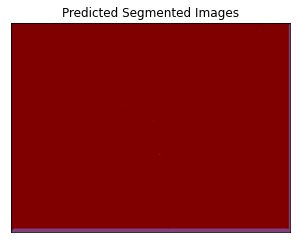

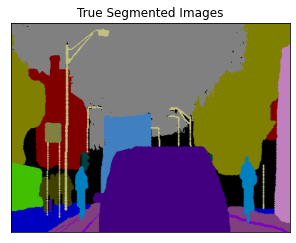

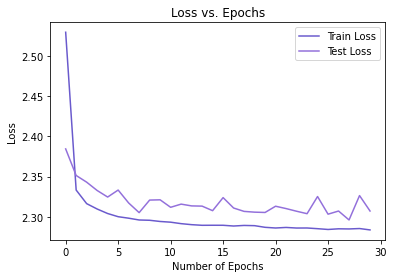

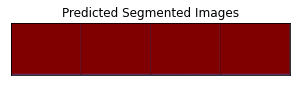

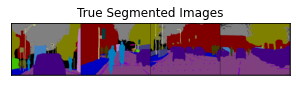

In [ ]:
train(mySegNet, criterion, optimizer, batchTrainDataset, batchTestDataset, 30)

Epoch 1 has started......
Training the network......
Iteration:10 	 Loss:2.32456
Iteration:20 	 Loss:2.33281
Iteration:30 	 Loss:2.30892
Iteration:40 	 Loss:2.28471
Iteration:50 	 Loss:2.26944
Iteration:60 	 Loss:2.27098
Iteration:70 	 Loss:2.27321
Iteration:80 	 Loss:2.27780
Iteration:90 	 Loss:2.27845
Iteration:100 	 Loss:2.28012
Iteration:110 	 Loss:2.28395
Iteration:120 	 Loss:2.28204
Iteration:130 	 Loss:2.27931
Iteration:140 	 Loss:2.28360
Testing the network......
At the end of epoch 1 the average train loss is: 2.28360
At the end of epoch 1 the average test loss is: 2.30284


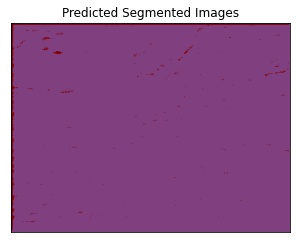

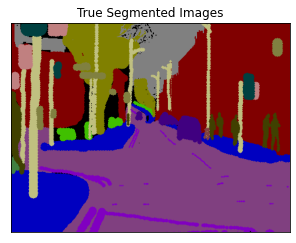

Epoch 2 has started......
Training the network......
Iteration:10 	 Loss:2.26250
Iteration:20 	 Loss:2.26499
Iteration:30 	 Loss:2.28405
Iteration:40 	 Loss:2.28049
Iteration:50 	 Loss:2.27327
Iteration:60 	 Loss:2.27018
Iteration:70 	 Loss:2.27814
Iteration:80 	 Loss:2.28271
Iteration:90 	 Loss:2.28407
Iteration:100 	 Loss:2.28209
Iteration:110 	 Loss:2.28262
Iteration:120 	 Loss:2.28908
Iteration:130 	 Loss:2.28893
Iteration:140 	 Loss:2.28404
Testing the network......
At the end of epoch 2 the average train loss is: 2.28404
At the end of epoch 2 the average test loss is: 2.31067


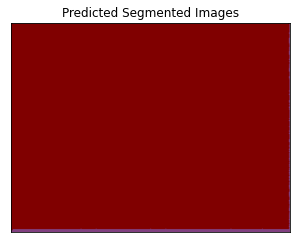

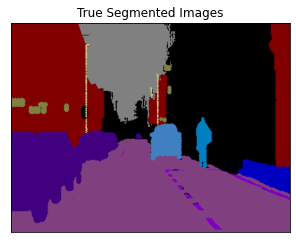

Epoch 3 has started......
Training the network......
Iteration:10 	 Loss:2.26390
Iteration:20 	 Loss:2.28041
Iteration:30 	 Loss:2.26628
Iteration:40 	 Loss:2.26652
Iteration:50 	 Loss:2.27204
Iteration:60 	 Loss:2.27724
Iteration:70 	 Loss:2.27049
Iteration:80 	 Loss:2.27069
Iteration:90 	 Loss:2.27267
Iteration:100 	 Loss:2.27771
Iteration:110 	 Loss:2.28298
Iteration:120 	 Loss:2.28038
Iteration:130 	 Loss:2.28339
Iteration:140 	 Loss:2.28350
Testing the network......
At the end of epoch 3 the average train loss is: 2.28350
At the end of epoch 3 the average test loss is: 2.31312


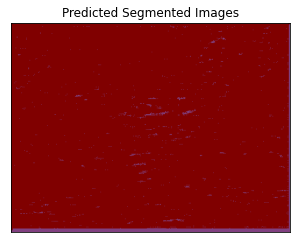

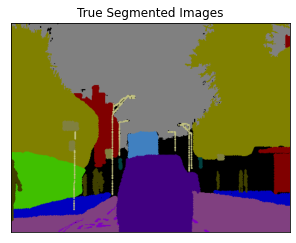

Epoch 4 has started......
Training the network......
Iteration:10 	 Loss:2.28076
Iteration:20 	 Loss:2.28025
Iteration:30 	 Loss:2.29813
Iteration:40 	 Loss:2.27486
Iteration:50 	 Loss:2.28770
Iteration:60 	 Loss:2.28150
Iteration:70 	 Loss:2.27391
Iteration:80 	 Loss:2.27431
Iteration:90 	 Loss:2.27418
Iteration:100 	 Loss:2.27306
Iteration:110 	 Loss:2.27882
Iteration:120 	 Loss:2.28395
Iteration:130 	 Loss:2.28618
Iteration:140 	 Loss:2.28211
Testing the network......
At the end of epoch 4 the average train loss is: 2.28211
At the end of epoch 4 the average test loss is: 2.30700


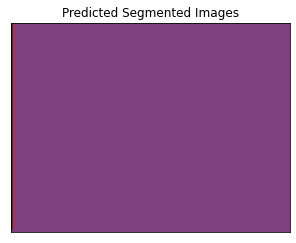

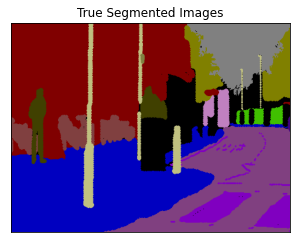

Epoch 5 has started......
Training the network......
Iteration:10 	 Loss:2.33373
Iteration:20 	 Loss:2.32321
Iteration:30 	 Loss:2.30286
Iteration:40 	 Loss:2.28675
Iteration:50 	 Loss:2.27523
Iteration:60 	 Loss:2.28735
Iteration:70 	 Loss:2.29016
Iteration:80 	 Loss:2.29143
Iteration:90 	 Loss:2.28882
Iteration:100 	 Loss:2.28779
Iteration:110 	 Loss:2.28752
Iteration:120 	 Loss:2.28644
Iteration:130 	 Loss:2.28069
Iteration:140 	 Loss:2.28326
Testing the network......
At the end of epoch 5 the average train loss is: 2.28326
At the end of epoch 5 the average test loss is: 2.32502


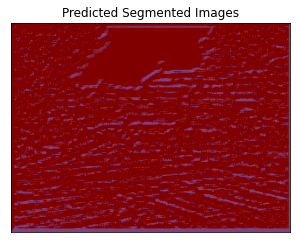

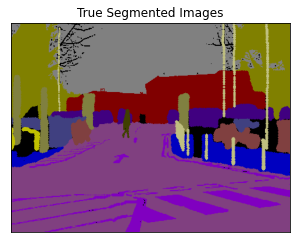

Epoch 6 has started......
Training the network......
Iteration:10 	 Loss:2.29274
Iteration:20 	 Loss:2.31124
Iteration:30 	 Loss:2.29118
Iteration:40 	 Loss:2.29079
Iteration:50 	 Loss:2.28051
Iteration:60 	 Loss:2.27510
Iteration:70 	 Loss:2.27644
Iteration:80 	 Loss:2.26655
Iteration:90 	 Loss:2.28533
Iteration:100 	 Loss:2.28647
Iteration:110 	 Loss:2.28485
Iteration:120 	 Loss:2.28394
Iteration:130 	 Loss:2.28046
Iteration:140 	 Loss:2.28338
Testing the network......
At the end of epoch 6 the average train loss is: 2.28338
At the end of epoch 6 the average test loss is: 2.31530


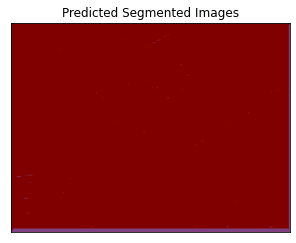

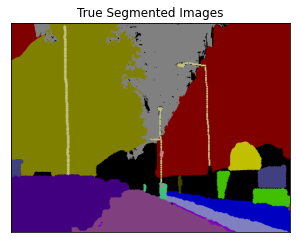

Epoch 7 has started......
Training the network......
Iteration:10 	 Loss:2.25138
Iteration:20 	 Loss:2.27994
Iteration:30 	 Loss:2.28966
Iteration:40 	 Loss:2.28004
Iteration:50 	 Loss:2.26986
Iteration:60 	 Loss:2.26899
Iteration:70 	 Loss:2.27334
Iteration:80 	 Loss:2.27415
Iteration:90 	 Loss:2.28109
Iteration:100 	 Loss:2.28103
Iteration:110 	 Loss:2.28582
Iteration:120 	 Loss:2.28644
Iteration:130 	 Loss:2.28351
Iteration:140 	 Loss:2.28224
Testing the network......
At the end of epoch 7 the average train loss is: 2.28224
At the end of epoch 7 the average test loss is: 2.30524


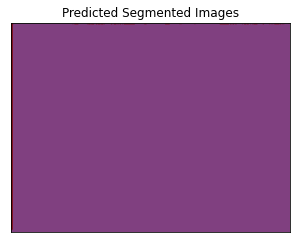

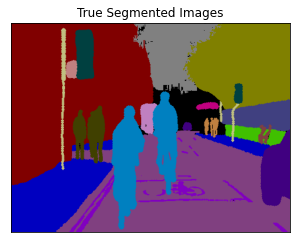

Epoch 8 has started......
Training the network......
Iteration:10 	 Loss:2.38508
Iteration:20 	 Loss:2.32591
Iteration:30 	 Loss:2.32400
Iteration:40 	 Loss:2.30813
Iteration:50 	 Loss:2.31316
Iteration:60 	 Loss:2.29871
Iteration:70 	 Loss:2.29903
Iteration:80 	 Loss:2.28996
Iteration:90 	 Loss:2.28297
Iteration:100 	 Loss:2.28558
Iteration:110 	 Loss:2.28147
Iteration:120 	 Loss:2.27863
Iteration:130 	 Loss:2.27831
Iteration:140 	 Loss:2.28075
Testing the network......
At the end of epoch 8 the average train loss is: 2.28075
At the end of epoch 8 the average test loss is: 2.29912


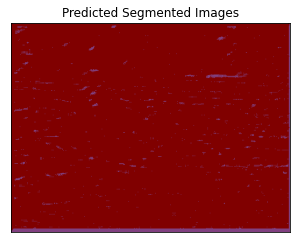

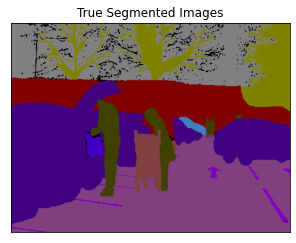

Epoch 9 has started......
Training the network......
Iteration:10 	 Loss:2.29995
Iteration:20 	 Loss:2.29767
Iteration:30 	 Loss:2.28372
Iteration:40 	 Loss:2.28518
Iteration:50 	 Loss:2.27736
Iteration:60 	 Loss:2.28246
Iteration:70 	 Loss:2.27939
Iteration:80 	 Loss:2.27913
Iteration:90 	 Loss:2.27272
Iteration:100 	 Loss:2.27782
Iteration:110 	 Loss:2.27313
Iteration:120 	 Loss:2.27492
Iteration:130 	 Loss:2.27735
Iteration:140 	 Loss:2.28311
Testing the network......
At the end of epoch 9 the average train loss is: 2.28311
At the end of epoch 9 the average test loss is: 2.30937


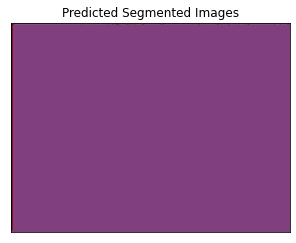

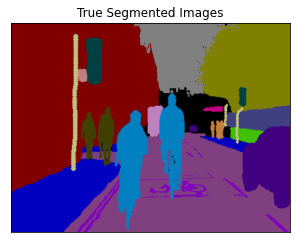

Epoch 10 has started......
Training the network......
Iteration:10 	 Loss:2.24827
Iteration:20 	 Loss:2.29358
Iteration:30 	 Loss:2.30000
Iteration:40 	 Loss:2.30247
Iteration:50 	 Loss:2.29450
Iteration:60 	 Loss:2.29451
Iteration:70 	 Loss:2.28689
Iteration:80 	 Loss:2.28676
Iteration:90 	 Loss:2.28667
Iteration:100 	 Loss:2.28093
Iteration:110 	 Loss:2.27954
Iteration:120 	 Loss:2.28364
Iteration:130 	 Loss:2.28574
Iteration:140 	 Loss:2.28315
Testing the network......
At the end of epoch 10 the average train loss is: 2.28315
At the end of epoch 10 the average test loss is: 2.30203


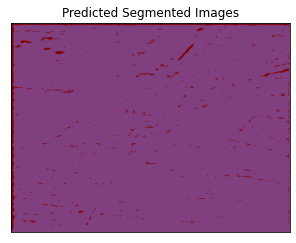

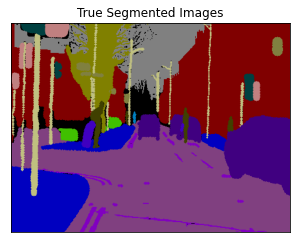

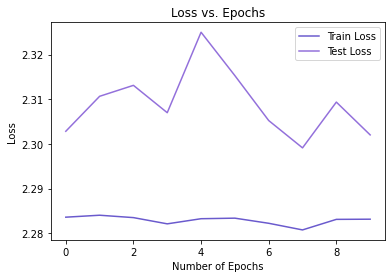

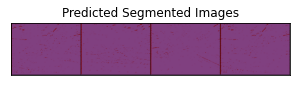

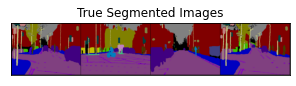

In [ ]:
train(mySegNet, criterion, optimizer, batchTrainDataset, batchTestDataset, 10)

##  <font color=MediumSlateBlue>Trainning and Plotting Required Plots without Batch Normalization with Adam Optimizer</font> ##

In [ ]:
mySegNet = SegNet(3, 32, batchNormCondition=False)

if torch.cuda.is_available():
     mySegNet = mySegNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mySegNet.parameters(), lr=0.001, weight_decay=0.005)

####  <font color=SlateBlue>Trainning the Network</font> ####

Epoch 1 has started......
Training the network......
Iteration:10 	 Loss:2.79952
Iteration:20 	 Loss:2.59289
Iteration:30 	 Loss:2.51051
Iteration:40 	 Loss:2.47979
Iteration:50 	 Loss:2.45066
Iteration:60 	 Loss:2.44415
Iteration:70 	 Loss:2.42683
Iteration:80 	 Loss:2.39261
Iteration:90 	 Loss:2.37590
Iteration:100 	 Loss:2.35456
Iteration:110 	 Loss:2.35031
Iteration:120 	 Loss:2.33137
Iteration:130 	 Loss:2.32009
Iteration:140 	 Loss:2.29060
Testing the network......
At the end of epoch 1 the average train loss is: 2.29060
At the end of epoch 1 the average test loss is: 1.85400


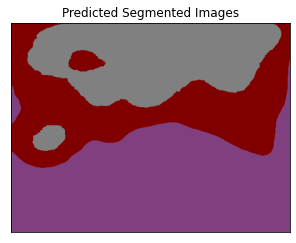

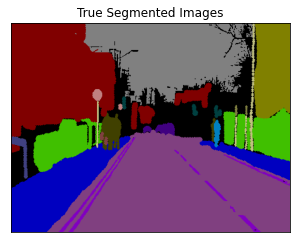

Epoch 2 has started......
Training the network......
Iteration:10 	 Loss:1.93434
Iteration:20 	 Loss:1.87258
Iteration:30 	 Loss:1.86178
Iteration:40 	 Loss:1.85761
Iteration:50 	 Loss:1.88217
Iteration:60 	 Loss:1.86076
Iteration:70 	 Loss:1.84938
Iteration:80 	 Loss:1.87104
Iteration:90 	 Loss:1.87216
Iteration:100 	 Loss:1.88279
Iteration:110 	 Loss:1.88292
Iteration:120 	 Loss:1.87073
Iteration:130 	 Loss:1.86250
Iteration:140 	 Loss:1.85097
Testing the network......
At the end of epoch 2 the average train loss is: 1.85097
At the end of epoch 2 the average test loss is: 1.81680


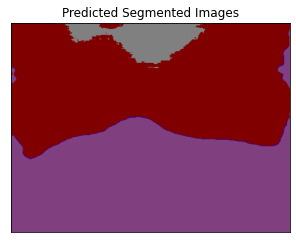

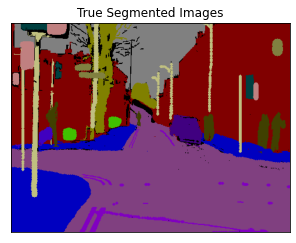

Epoch 3 has started......
Training the network......
Iteration:10 	 Loss:1.80836
Iteration:20 	 Loss:1.84537
Iteration:30 	 Loss:1.91598
Iteration:40 	 Loss:1.88985
Iteration:50 	 Loss:1.88536
Iteration:60 	 Loss:1.87364
Iteration:70 	 Loss:1.86450
Iteration:80 	 Loss:1.83617
Iteration:90 	 Loss:1.82434
Iteration:100 	 Loss:1.81214
Iteration:110 	 Loss:1.79990
Iteration:120 	 Loss:1.79284
Iteration:130 	 Loss:1.78532
Iteration:140 	 Loss:1.77726
Testing the network......
At the end of epoch 3 the average train loss is: 1.77726
At the end of epoch 3 the average test loss is: 1.66155


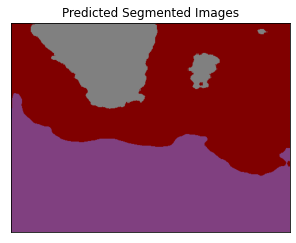

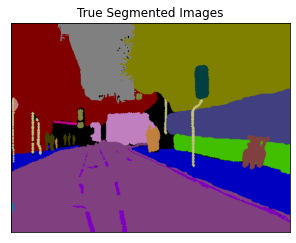

Epoch 4 has started......
Training the network......
Iteration:10 	 Loss:1.64184
Iteration:20 	 Loss:1.59876
Iteration:30 	 Loss:1.62812
Iteration:40 	 Loss:1.64683
Iteration:50 	 Loss:1.65495
Iteration:60 	 Loss:1.65582
Iteration:70 	 Loss:1.64192
Iteration:80 	 Loss:1.65996
Iteration:90 	 Loss:1.65578
Iteration:100 	 Loss:1.65168
Iteration:110 	 Loss:1.64627
Iteration:120 	 Loss:1.66036
Iteration:130 	 Loss:1.66334
Iteration:140 	 Loss:1.65953
Testing the network......
At the end of epoch 4 the average train loss is: 1.65953
At the end of epoch 4 the average test loss is: 1.58464


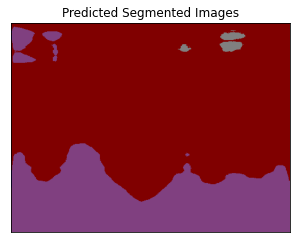

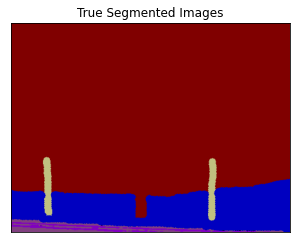

Epoch 5 has started......
Training the network......
Iteration:10 	 Loss:1.65412
Iteration:20 	 Loss:1.66587
Iteration:30 	 Loss:1.62794
Iteration:40 	 Loss:1.62645
Iteration:50 	 Loss:1.60774
Iteration:60 	 Loss:1.58389
Iteration:70 	 Loss:1.57297
Iteration:80 	 Loss:1.58587
Iteration:90 	 Loss:1.59738
Iteration:100 	 Loss:1.59439
Iteration:110 	 Loss:1.60715
Iteration:120 	 Loss:1.59886
Iteration:130 	 Loss:1.60262
Iteration:140 	 Loss:1.60713
Testing the network......
At the end of epoch 5 the average train loss is: 1.60713
At the end of epoch 5 the average test loss is: 1.52068


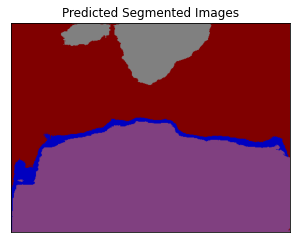

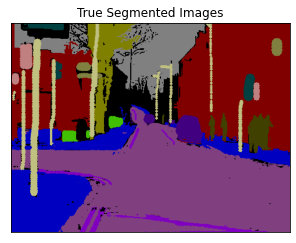

Epoch 6 has started......
Training the network......
Iteration:10 	 Loss:1.56056
Iteration:20 	 Loss:1.59153
Iteration:30 	 Loss:1.55956
Iteration:40 	 Loss:1.56122
Iteration:50 	 Loss:1.56073
Iteration:60 	 Loss:1.55933
Iteration:70 	 Loss:1.54769
Iteration:80 	 Loss:1.55477
Iteration:90 	 Loss:1.57681
Iteration:100 	 Loss:1.57444
Iteration:110 	 Loss:1.56372
Iteration:120 	 Loss:1.57145
Iteration:130 	 Loss:1.57453
Iteration:140 	 Loss:1.57384
Testing the network......
At the end of epoch 6 the average train loss is: 1.57384
At the end of epoch 6 the average test loss is: 1.46562


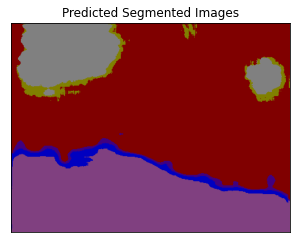

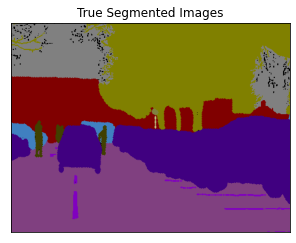

Epoch 7 has started......
Training the network......
Iteration:10 	 Loss:1.40481
Iteration:20 	 Loss:1.45697
Iteration:30 	 Loss:1.46792
Iteration:40 	 Loss:1.50544
Iteration:50 	 Loss:1.49281
Iteration:60 	 Loss:1.47628
Iteration:70 	 Loss:1.46306
Iteration:80 	 Loss:1.48202
Iteration:90 	 Loss:1.48185
Iteration:100 	 Loss:1.46960
Iteration:110 	 Loss:1.47141
Iteration:120 	 Loss:1.48474
Iteration:130 	 Loss:1.49349
Iteration:140 	 Loss:1.49391
Testing the network......
At the end of epoch 7 the average train loss is: 1.49391
At the end of epoch 7 the average test loss is: 1.48132


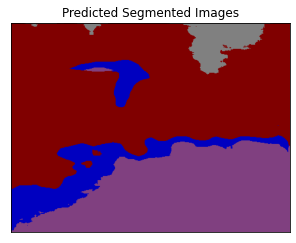

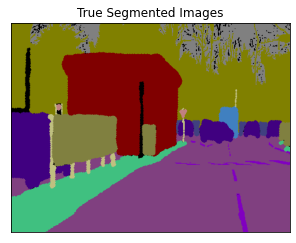

Epoch 8 has started......
Training the network......
Iteration:10 	 Loss:1.43004
Iteration:20 	 Loss:1.44950
Iteration:30 	 Loss:1.46786
Iteration:40 	 Loss:1.46228
Iteration:50 	 Loss:1.46923
Iteration:60 	 Loss:1.46996
Iteration:70 	 Loss:1.46386
Iteration:80 	 Loss:1.48390
Iteration:90 	 Loss:1.52506
Iteration:100 	 Loss:1.56804
Iteration:110 	 Loss:1.59136
Iteration:120 	 Loss:1.60454
Iteration:130 	 Loss:1.59790
Iteration:140 	 Loss:1.60263
Testing the network......
At the end of epoch 8 the average train loss is: 1.60263
At the end of epoch 8 the average test loss is: 1.72148


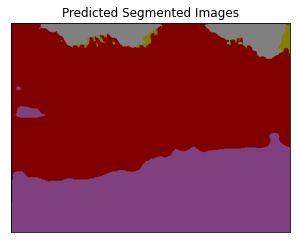

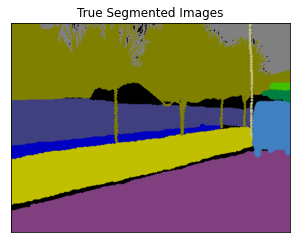

Epoch 9 has started......
Training the network......
Iteration:10 	 Loss:1.50251
Iteration:20 	 Loss:1.57599
Iteration:30 	 Loss:1.58452
Iteration:40 	 Loss:1.55243
Iteration:50 	 Loss:1.53885
Iteration:60 	 Loss:1.54586
Iteration:70 	 Loss:1.53676
Iteration:80 	 Loss:1.52624
Iteration:90 	 Loss:1.52228
Iteration:100 	 Loss:1.52829
Iteration:110 	 Loss:1.51893
Iteration:120 	 Loss:1.51759
Iteration:130 	 Loss:1.55708
Iteration:140 	 Loss:1.57189
Testing the network......
At the end of epoch 9 the average train loss is: 1.57189
At the end of epoch 9 the average test loss is: 1.54545


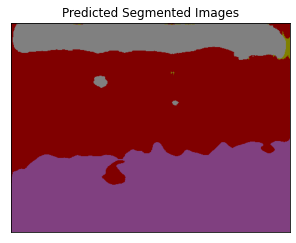

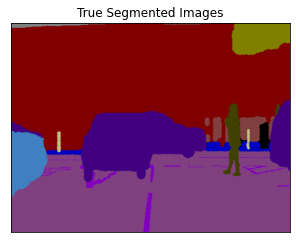

Epoch 10 has started......
Training the network......
Iteration:10 	 Loss:1.55222
Iteration:20 	 Loss:1.49819
Iteration:30 	 Loss:1.51485
Iteration:40 	 Loss:1.55416
Iteration:50 	 Loss:1.53420
Iteration:60 	 Loss:1.50907
Iteration:70 	 Loss:1.49771
Iteration:80 	 Loss:1.51257
Iteration:90 	 Loss:1.50309
Iteration:100 	 Loss:1.50971
Iteration:110 	 Loss:1.51741
Iteration:120 	 Loss:1.53058
Iteration:130 	 Loss:1.52817
Iteration:140 	 Loss:1.52369
Testing the network......
At the end of epoch 10 the average train loss is: 1.52369
At the end of epoch 10 the average test loss is: 1.44223


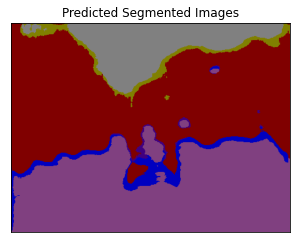

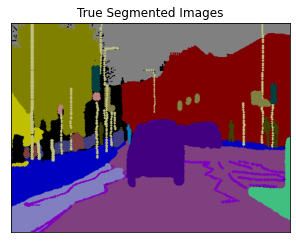

Epoch 11 has started......
Training the network......
Iteration:10 	 Loss:1.38085
Iteration:20 	 Loss:1.45542
Iteration:30 	 Loss:1.46898
Iteration:40 	 Loss:1.46507
Iteration:50 	 Loss:1.48080
Iteration:60 	 Loss:1.47099
Iteration:70 	 Loss:1.46752
Iteration:80 	 Loss:1.46255
Iteration:90 	 Loss:1.44855
Iteration:100 	 Loss:1.45101
Iteration:110 	 Loss:1.45044
Iteration:120 	 Loss:1.44349
Iteration:130 	 Loss:1.44251
Iteration:140 	 Loss:1.43513
Testing the network......
At the end of epoch 11 the average train loss is: 1.43513
At the end of epoch 11 the average test loss is: 1.32838


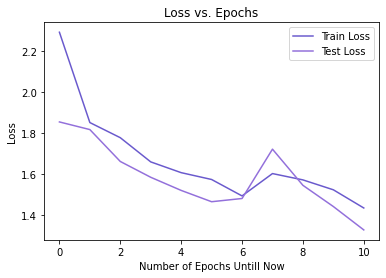

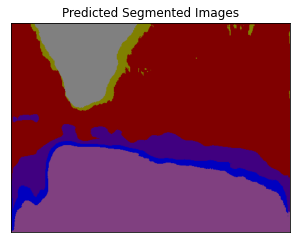

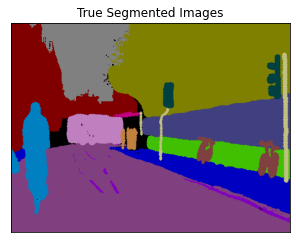

Epoch 12 has started......
Training the network......
Iteration:10 	 Loss:1.33885
Iteration:20 	 Loss:1.36008
Iteration:30 	 Loss:1.36301
Iteration:40 	 Loss:1.38783
Iteration:50 	 Loss:1.38708
Iteration:60 	 Loss:1.42807
Iteration:70 	 Loss:1.44097
Iteration:80 	 Loss:1.43870
Iteration:90 	 Loss:1.44139
Iteration:100 	 Loss:1.43370
Iteration:110 	 Loss:1.43166
Iteration:120 	 Loss:1.43212
Iteration:130 	 Loss:1.43166
Iteration:140 	 Loss:1.42494
Testing the network......
At the end of epoch 12 the average train loss is: 1.42494
At the end of epoch 12 the average test loss is: 1.33546


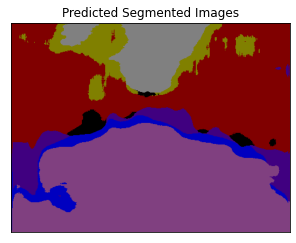

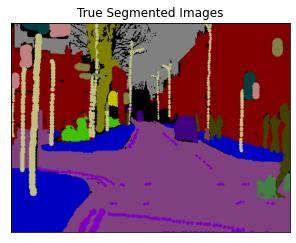

Epoch 13 has started......
Training the network......
Iteration:10 	 Loss:1.39388
Iteration:20 	 Loss:1.41627
Iteration:30 	 Loss:1.40793
Iteration:40 	 Loss:1.39928
Iteration:50 	 Loss:1.39337
Iteration:60 	 Loss:1.39712
Iteration:70 	 Loss:1.38331
Iteration:80 	 Loss:1.38559
Iteration:90 	 Loss:1.38702
Iteration:100 	 Loss:1.38269
Iteration:110 	 Loss:1.38333
Iteration:120 	 Loss:1.38931
Iteration:130 	 Loss:1.38699
Iteration:140 	 Loss:1.38329
Testing the network......
At the end of epoch 13 the average train loss is: 1.38329
At the end of epoch 13 the average test loss is: 1.28787


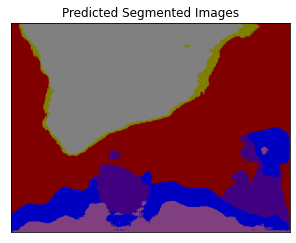

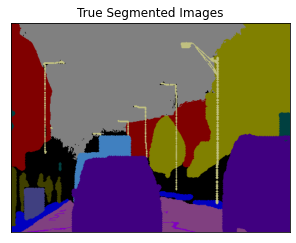

Epoch 14 has started......
Training the network......
Iteration:10 	 Loss:1.29751
Iteration:20 	 Loss:1.38630
Iteration:30 	 Loss:1.36411
Iteration:40 	 Loss:1.34017
Iteration:50 	 Loss:1.34827
Iteration:60 	 Loss:1.34230
Iteration:70 	 Loss:1.33628
Iteration:80 	 Loss:1.33860
Iteration:90 	 Loss:1.34465
Iteration:100 	 Loss:1.33875
Iteration:110 	 Loss:1.34157
Iteration:120 	 Loss:1.35420
Iteration:130 	 Loss:1.36139
Iteration:140 	 Loss:1.35957
Testing the network......
At the end of epoch 14 the average train loss is: 1.35957
At the end of epoch 14 the average test loss is: 1.33898


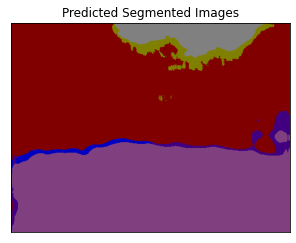

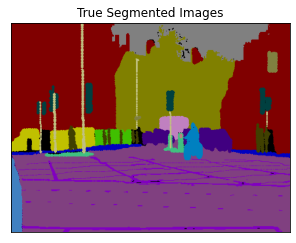

Epoch 15 has started......
Training the network......
Iteration:10 	 Loss:1.30706
Iteration:20 	 Loss:1.31241
Iteration:30 	 Loss:1.29342
Iteration:40 	 Loss:1.29601
Iteration:50 	 Loss:1.30940
Iteration:60 	 Loss:1.31645
Iteration:70 	 Loss:1.32278
Iteration:80 	 Loss:1.31987
Iteration:90 	 Loss:1.32747
Iteration:100 	 Loss:1.32233
Iteration:110 	 Loss:1.31877
Iteration:120 	 Loss:1.32297
Iteration:130 	 Loss:1.32027
Iteration:140 	 Loss:1.32395
Testing the network......
At the end of epoch 15 the average train loss is: 1.32395
At the end of epoch 15 the average test loss is: 1.28403


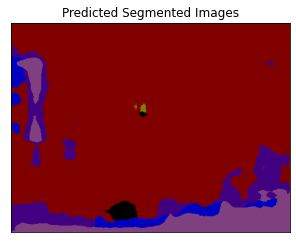

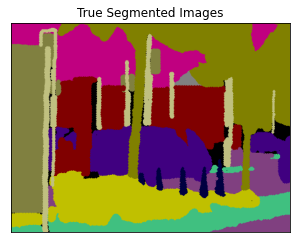

Epoch 16 has started......
Training the network......
Iteration:10 	 Loss:1.35452
Iteration:20 	 Loss:1.31795
Iteration:30 	 Loss:1.32516
Iteration:40 	 Loss:1.34201
Iteration:50 	 Loss:1.34390
Iteration:60 	 Loss:1.33900
Iteration:70 	 Loss:1.32335
Iteration:80 	 Loss:1.30602
Iteration:90 	 Loss:1.31675
Iteration:100 	 Loss:1.31004
Iteration:110 	 Loss:1.31710
Iteration:120 	 Loss:1.31983
Iteration:130 	 Loss:1.31728
Iteration:140 	 Loss:1.31837
Testing the network......
At the end of epoch 16 the average train loss is: 1.31837
At the end of epoch 16 the average test loss is: 1.26245


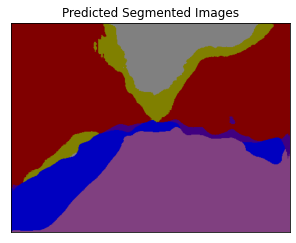

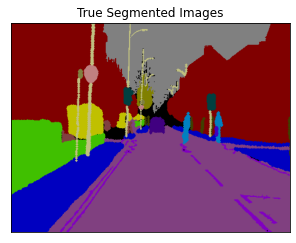

Epoch 17 has started......
Training the network......
Iteration:10 	 Loss:1.26826
Iteration:20 	 Loss:1.27821
Iteration:30 	 Loss:1.26673
Iteration:40 	 Loss:1.27315
Iteration:50 	 Loss:1.27803
Iteration:60 	 Loss:1.27455
Iteration:70 	 Loss:1.27775
Iteration:80 	 Loss:1.28996
Iteration:90 	 Loss:1.29361
Iteration:100 	 Loss:1.28902
Iteration:110 	 Loss:1.29447
Iteration:120 	 Loss:1.29403
Iteration:130 	 Loss:1.29044
Iteration:140 	 Loss:1.29548
Testing the network......
At the end of epoch 17 the average train loss is: 1.29548
At the end of epoch 17 the average test loss is: 1.26663


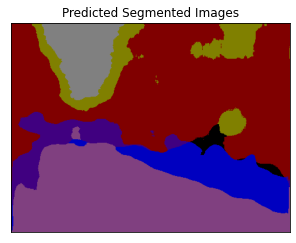

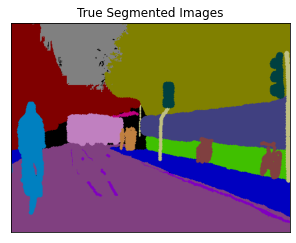

Epoch 18 has started......
Training the network......
Iteration:10 	 Loss:1.33552
Iteration:20 	 Loss:1.35427
Iteration:30 	 Loss:1.33999
Iteration:40 	 Loss:1.31800
Iteration:50 	 Loss:1.29983
Iteration:60 	 Loss:1.29124
Iteration:70 	 Loss:1.30004
Iteration:80 	 Loss:1.29822
Iteration:90 	 Loss:1.30631
Iteration:100 	 Loss:1.30362
Iteration:110 	 Loss:1.30684
Iteration:120 	 Loss:1.30952
Iteration:130 	 Loss:1.29743
Iteration:140 	 Loss:1.29357
Testing the network......
At the end of epoch 18 the average train loss is: 1.29357
At the end of epoch 18 the average test loss is: 1.23376


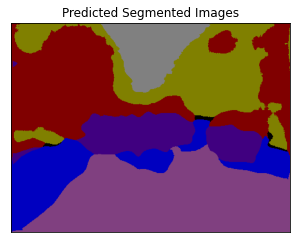

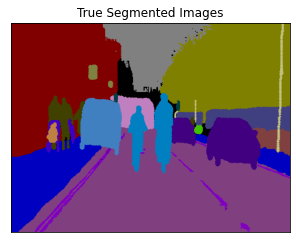

Epoch 19 has started......
Training the network......
Iteration:10 	 Loss:1.28410
Iteration:20 	 Loss:1.22278
Iteration:30 	 Loss:1.20903
Iteration:40 	 Loss:1.22376
Iteration:50 	 Loss:1.23497
Iteration:60 	 Loss:1.22924
Iteration:70 	 Loss:1.22829
Iteration:80 	 Loss:1.23134
Iteration:90 	 Loss:1.23310
Iteration:100 	 Loss:1.25186
Iteration:110 	 Loss:1.26704
Iteration:120 	 Loss:1.27225
Iteration:130 	 Loss:1.27253
Iteration:140 	 Loss:1.27468
Testing the network......
At the end of epoch 19 the average train loss is: 1.27468
At the end of epoch 19 the average test loss is: 1.27692


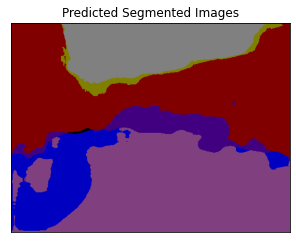

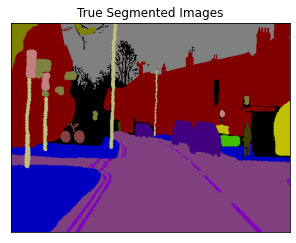

Epoch 20 has started......
Training the network......
Iteration:10 	 Loss:1.25828
Iteration:20 	 Loss:1.27321
Iteration:30 	 Loss:1.27329
Iteration:40 	 Loss:1.32244
Iteration:50 	 Loss:1.32617
Iteration:60 	 Loss:1.30707
Iteration:70 	 Loss:1.31311
Iteration:80 	 Loss:1.29891
Iteration:90 	 Loss:1.29616
Iteration:100 	 Loss:1.29179
Iteration:110 	 Loss:1.30481
Iteration:120 	 Loss:1.31443
Iteration:130 	 Loss:1.31259
Iteration:140 	 Loss:1.31260
Testing the network......
At the end of epoch 20 the average train loss is: 1.31260
At the end of epoch 20 the average test loss is: 1.22558


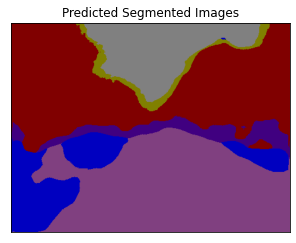

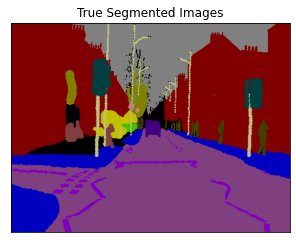

Epoch 21 has started......
Training the network......
Iteration:10 	 Loss:1.24001
Iteration:20 	 Loss:1.28829
Iteration:30 	 Loss:1.26015
Iteration:40 	 Loss:1.23167
Iteration:50 	 Loss:1.26463
Iteration:60 	 Loss:1.27592
Iteration:70 	 Loss:1.28758
Iteration:80 	 Loss:1.29788
Iteration:90 	 Loss:1.31852
Iteration:100 	 Loss:1.31022
Iteration:110 	 Loss:1.30275
Iteration:120 	 Loss:1.30508
Iteration:130 	 Loss:1.30862
Iteration:140 	 Loss:1.30247
Testing the network......
At the end of epoch 21 the average train loss is: 1.30247
At the end of epoch 21 the average test loss is: 1.24490


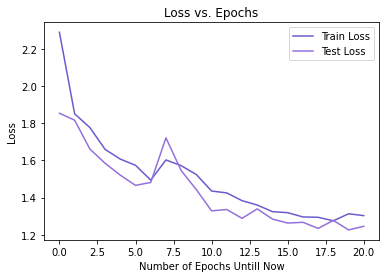

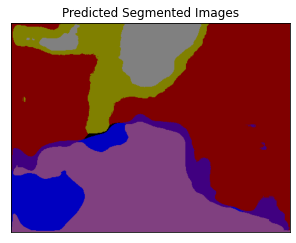

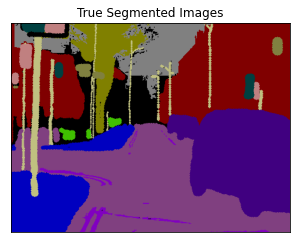

Epoch 22 has started......
Training the network......
Iteration:10 	 Loss:1.25642
Iteration:20 	 Loss:1.29461
Iteration:30 	 Loss:1.27176
Iteration:40 	 Loss:1.29205
Iteration:50 	 Loss:1.27356
Iteration:60 	 Loss:1.26612
Iteration:70 	 Loss:1.25133
Iteration:80 	 Loss:1.25572
Iteration:90 	 Loss:1.25185
Iteration:100 	 Loss:1.26240
Iteration:110 	 Loss:1.26271
Iteration:120 	 Loss:1.25987
Iteration:130 	 Loss:1.25643
Iteration:140 	 Loss:1.25438
Testing the network......
At the end of epoch 22 the average train loss is: 1.25438
At the end of epoch 22 the average test loss is: 1.21187


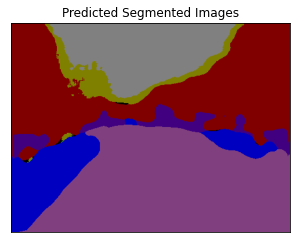

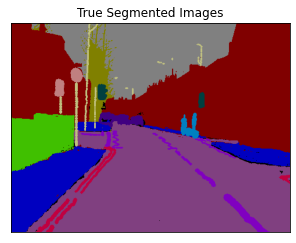

Epoch 23 has started......
Training the network......
Iteration:10 	 Loss:1.28042
Iteration:20 	 Loss:1.27793
Iteration:30 	 Loss:1.27833
Iteration:40 	 Loss:1.29484
Iteration:50 	 Loss:1.29006
Iteration:60 	 Loss:1.26951
Iteration:70 	 Loss:1.26706
Iteration:80 	 Loss:1.25247
Iteration:90 	 Loss:1.26129
Iteration:100 	 Loss:1.25788
Iteration:110 	 Loss:1.25910
Iteration:120 	 Loss:1.26127
Iteration:130 	 Loss:1.25979
Iteration:140 	 Loss:1.26008
Testing the network......
At the end of epoch 23 the average train loss is: 1.26008
At the end of epoch 23 the average test loss is: 1.20859


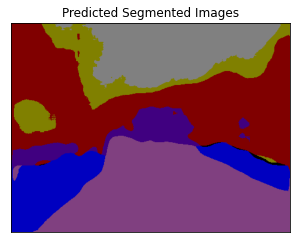

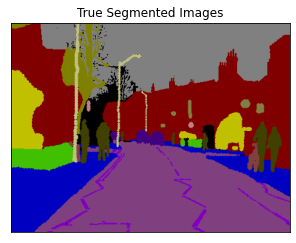

Epoch 24 has started......
Training the network......
Iteration:10 	 Loss:1.31759
Iteration:20 	 Loss:1.25957
Iteration:30 	 Loss:1.23167
Iteration:40 	 Loss:1.24875
Iteration:50 	 Loss:1.25747
Iteration:60 	 Loss:1.25467
Iteration:70 	 Loss:1.23736
Iteration:80 	 Loss:1.23975
Iteration:90 	 Loss:1.23866
Iteration:100 	 Loss:1.24176
Iteration:110 	 Loss:1.23572
Iteration:120 	 Loss:1.23626
Iteration:130 	 Loss:1.24062
Iteration:140 	 Loss:1.24111
Testing the network......
At the end of epoch 24 the average train loss is: 1.24111
At the end of epoch 24 the average test loss is: 1.17862


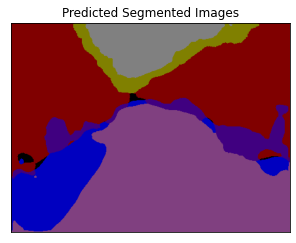

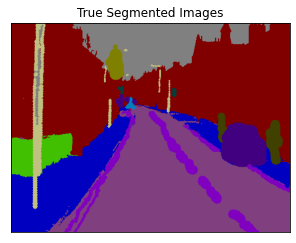

Epoch 25 has started......
Training the network......
Iteration:10 	 Loss:1.25860
Iteration:20 	 Loss:1.23790
Iteration:30 	 Loss:1.22954
Iteration:40 	 Loss:1.23508
Iteration:50 	 Loss:1.22648
Iteration:60 	 Loss:1.21619
Iteration:70 	 Loss:1.20690
Iteration:80 	 Loss:1.21436
Iteration:90 	 Loss:1.20017
Iteration:100 	 Loss:1.20705
Iteration:110 	 Loss:1.21054
Iteration:120 	 Loss:1.21562
Iteration:130 	 Loss:1.21752
Iteration:140 	 Loss:1.22200
Testing the network......
At the end of epoch 25 the average train loss is: 1.22200
At the end of epoch 25 the average test loss is: 1.16858


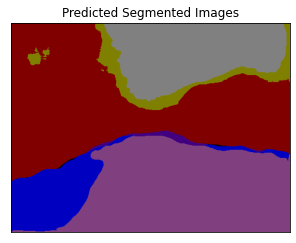

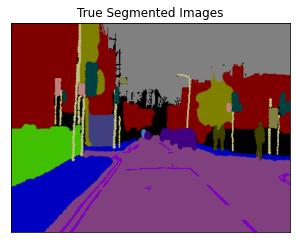

Epoch 26 has started......
Training the network......
Iteration:10 	 Loss:1.12328
Iteration:20 	 Loss:1.11479
Iteration:30 	 Loss:1.15474
Iteration:40 	 Loss:1.15828
Iteration:50 	 Loss:1.16988
Iteration:60 	 Loss:1.17982
Iteration:70 	 Loss:1.19912
Iteration:80 	 Loss:1.18785
Iteration:90 	 Loss:1.19356
Iteration:100 	 Loss:1.20284
Iteration:110 	 Loss:1.20914
Iteration:120 	 Loss:1.24296
Iteration:130 	 Loss:1.27787
Iteration:140 	 Loss:1.28571
Testing the network......
At the end of epoch 26 the average train loss is: 1.28571
At the end of epoch 26 the average test loss is: 1.28688


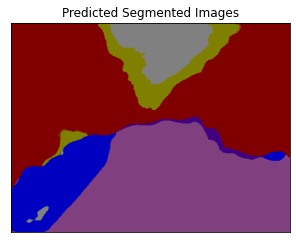

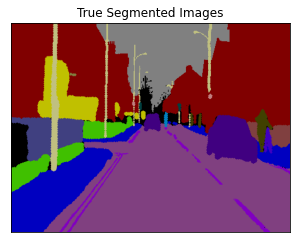

Epoch 27 has started......
Training the network......
Iteration:10 	 Loss:1.29133
Iteration:20 	 Loss:1.32766
Iteration:30 	 Loss:1.30314
Iteration:40 	 Loss:1.29916
Iteration:50 	 Loss:1.30642
Iteration:60 	 Loss:1.31020
Iteration:70 	 Loss:1.31221
Iteration:80 	 Loss:1.31179
Iteration:90 	 Loss:1.29450
Iteration:100 	 Loss:1.28909
Iteration:110 	 Loss:1.28016
Iteration:120 	 Loss:1.28383
Iteration:130 	 Loss:1.28028
Iteration:140 	 Loss:1.28259
Testing the network......
At the end of epoch 27 the average train loss is: 1.28259
At the end of epoch 27 the average test loss is: 1.21876


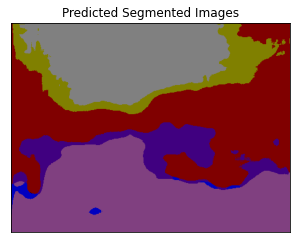

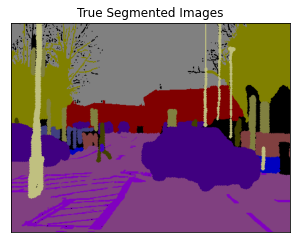

Epoch 28 has started......
Training the network......
Iteration:10 	 Loss:1.22963
Iteration:20 	 Loss:1.22736
Iteration:30 	 Loss:1.20765
Iteration:40 	 Loss:1.21897
Iteration:50 	 Loss:1.20257
Iteration:60 	 Loss:1.18707
Iteration:70 	 Loss:1.19640
Iteration:80 	 Loss:1.19819
Iteration:90 	 Loss:1.19760
Iteration:100 	 Loss:1.20849
Iteration:110 	 Loss:1.20652
Iteration:120 	 Loss:1.21092
Iteration:130 	 Loss:1.21469
Iteration:140 	 Loss:1.21043
Testing the network......
At the end of epoch 28 the average train loss is: 1.21043
At the end of epoch 28 the average test loss is: 1.22032


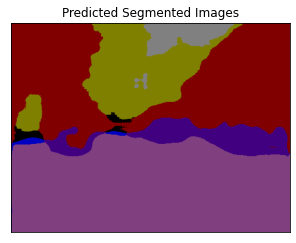

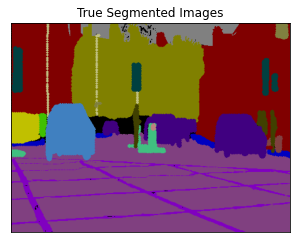

Epoch 29 has started......
Training the network......
Iteration:10 	 Loss:1.30928
Iteration:20 	 Loss:1.26721
Iteration:30 	 Loss:1.27206
Iteration:40 	 Loss:1.24223
Iteration:50 	 Loss:1.23766
Iteration:60 	 Loss:1.22721
Iteration:70 	 Loss:1.22648
Iteration:80 	 Loss:1.22372
Iteration:90 	 Loss:1.21260
Iteration:100 	 Loss:1.21161
Iteration:110 	 Loss:1.20587
Iteration:120 	 Loss:1.20326
Iteration:130 	 Loss:1.19707
Iteration:140 	 Loss:1.20065
Testing the network......
At the end of epoch 29 the average train loss is: 1.20065
At the end of epoch 29 the average test loss is: 1.19617


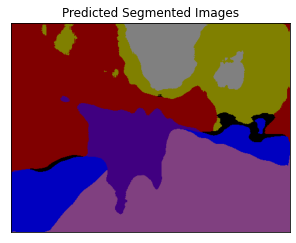

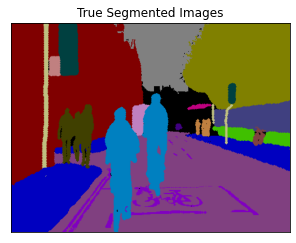

Epoch 30 has started......
Training the network......
Iteration:10 	 Loss:1.22876
Iteration:20 	 Loss:1.24840
Iteration:30 	 Loss:1.25681
Iteration:40 	 Loss:1.25316
Iteration:50 	 Loss:1.27149
Iteration:60 	 Loss:1.26309
Iteration:70 	 Loss:1.24576
Iteration:80 	 Loss:1.23486
Iteration:90 	 Loss:1.23726
Iteration:100 	 Loss:1.23267
Iteration:110 	 Loss:1.22563
Iteration:120 	 Loss:1.21850
Iteration:130 	 Loss:1.21002
Iteration:140 	 Loss:1.20026
Testing the network......
At the end of epoch 30 the average train loss is: 1.20026
At the end of epoch 30 the average test loss is: 1.15225


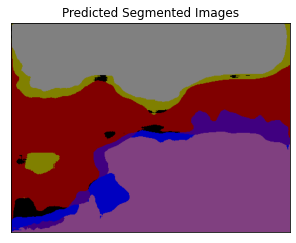

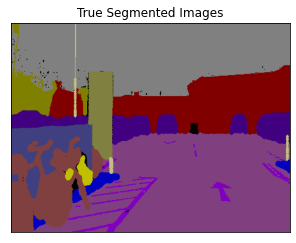

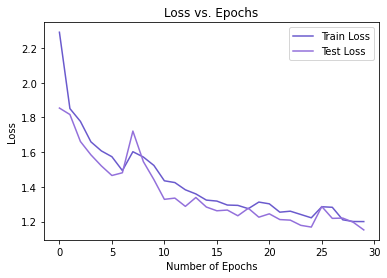

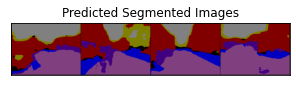

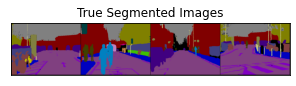

In [ ]:
train(mySegNet, criterion, optimizer, batchTrainDataset, batchTestDataset, 30)

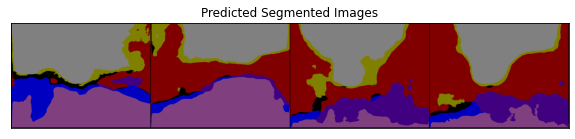

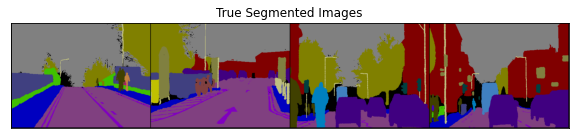

In [ ]:
def plotImages(net, batchTestDataset):
  with torch.no_grad():
    for testData, testLabels in batchTestDataset:
      if torch.cuda.is_available():
        testData = Variable(testData).cuda()
        testLabels = Variable(testLabels).cuda()
      else:
        testData = Variable(testData)
        testLabels = Variable(testLabels)

      allTestPredLabels = net(testData)

      testPredLabels = allTestPredLabels.max(dim=1)[1].data.cpu()
      tensor = torch.ones((testData.shape), dtype=torch.short)
      newLabels = [(indextoRGB(testPredLabels[i,:,:], RGBRef)).numpy() for i in range(testData.shape[0])]
      showImgs(tensor.new_tensor(newLabels), 100, 'Predicted Segmented Images')

      labels = testLabels.data.cpu()
      tensor = torch.ones((labels.shape), dtype=torch.short)
      newLabels = [(indextoRGB(labels[i,:,:], RGBRef)).numpy() for i in range(testData.shape[0])]
      showImgs(tensor.new_tensor(newLabels), 100, 'True Segmented Images')

      break


plotImages(mySegNet, batchTestDataset)

##  <font color=MediumSlateBlue>Trainning and Plotting Required Plots with Batch Normalization</font> ##

In [ ]:
mySegNet = SegNet(3, 32, batchNormCondition=True)

if torch.cuda.is_available():
     mySegNet = mySegNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mySegNet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

####  <font color=SlateBlue>Trainning the Network</font> ####

Epoch 1 has started......
Training the network......
Iteration:10 	 Loss:3.61472
Iteration:20 	 Loss:3.57102
Iteration:30 	 Loss:3.40741
Iteration:40 	 Loss:3.12213
Iteration:50 	 Loss:2.89072
Iteration:60 	 Loss:2.68721
Iteration:70 	 Loss:2.57618
Iteration:80 	 Loss:2.46250
Iteration:90 	 Loss:2.36206
Iteration:100 	 Loss:2.30606
Iteration:110 	 Loss:2.23505
Iteration:120 	 Loss:2.19505
Iteration:130 	 Loss:2.14379
Iteration:140 	 Loss:2.10022
Testing the network......
At the end of epoch 1 the average train loss is: 2.10022
At the end of epoch 1 the average test loss is: 1.46723


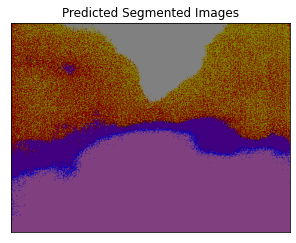

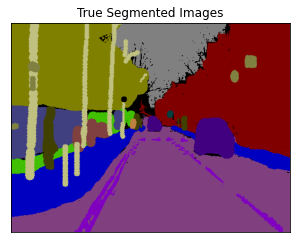

Epoch 2 has started......
Training the network......
Iteration:10 	 Loss:1.43012
Iteration:20 	 Loss:1.50237
Iteration:30 	 Loss:1.51608
Iteration:40 	 Loss:1.54352
Iteration:50 	 Loss:1.56109
Iteration:60 	 Loss:1.55002
Iteration:70 	 Loss:1.53032
Iteration:80 	 Loss:1.53594
Iteration:90 	 Loss:1.52209
Iteration:100 	 Loss:1.51811
Iteration:110 	 Loss:1.52165
Iteration:120 	 Loss:1.52382
Iteration:130 	 Loss:1.52464
Iteration:140 	 Loss:1.51544
Testing the network......
At the end of epoch 2 the average train loss is: 1.51544
At the end of epoch 2 the average test loss is: 1.34368


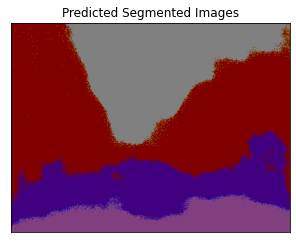

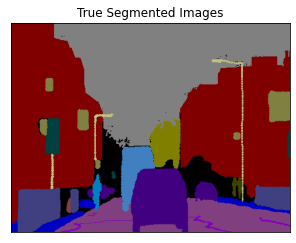

Epoch 3 has started......
Training the network......
Iteration:10 	 Loss:1.28649
Iteration:20 	 Loss:1.34972
Iteration:30 	 Loss:1.35363
Iteration:40 	 Loss:1.35004
Iteration:50 	 Loss:1.34186
Iteration:60 	 Loss:1.33731
Iteration:70 	 Loss:1.34750
Iteration:80 	 Loss:1.33698
Iteration:90 	 Loss:1.33995
Iteration:100 	 Loss:1.34278
Iteration:110 	 Loss:1.33391
Iteration:120 	 Loss:1.32464
Iteration:130 	 Loss:1.31786
Iteration:140 	 Loss:1.31309
Testing the network......
At the end of epoch 3 the average train loss is: 1.31309
At the end of epoch 3 the average test loss is: 1.26736


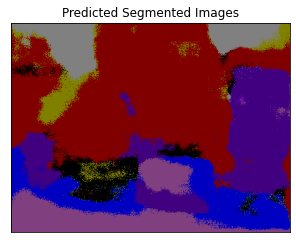

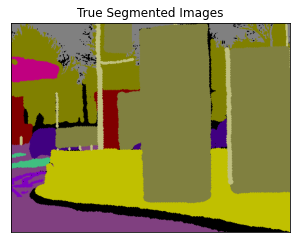

Epoch 4 has started......
Training the network......
Iteration:10 	 Loss:1.26507
Iteration:20 	 Loss:1.23478
Iteration:30 	 Loss:1.18827
Iteration:40 	 Loss:1.19605
Iteration:50 	 Loss:1.19490
Iteration:60 	 Loss:1.19710
Iteration:70 	 Loss:1.18646
Iteration:80 	 Loss:1.17855
Iteration:90 	 Loss:1.17277
Iteration:100 	 Loss:1.18457
Iteration:110 	 Loss:1.18925
Iteration:120 	 Loss:1.18653
Iteration:130 	 Loss:1.17547
Iteration:140 	 Loss:1.17036
Testing the network......
At the end of epoch 4 the average train loss is: 1.17036
At the end of epoch 4 the average test loss is: 1.22671


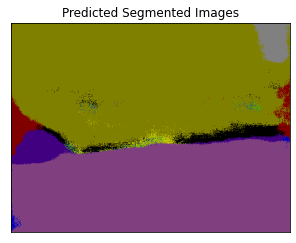

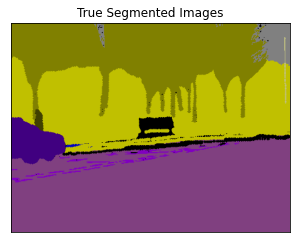

Epoch 5 has started......
Training the network......
Iteration:10 	 Loss:1.11226
Iteration:20 	 Loss:1.07933
Iteration:30 	 Loss:1.10289
Iteration:40 	 Loss:1.09432
Iteration:50 	 Loss:1.07447
Iteration:60 	 Loss:1.07089
Iteration:70 	 Loss:1.07506
Iteration:80 	 Loss:1.08889
Iteration:90 	 Loss:1.08275
Iteration:100 	 Loss:1.09359
Iteration:110 	 Loss:1.09112
Iteration:120 	 Loss:1.10073
Iteration:130 	 Loss:1.10484
Iteration:140 	 Loss:1.10526
Testing the network......
At the end of epoch 5 the average train loss is: 1.10526
At the end of epoch 5 the average test loss is: 1.12189


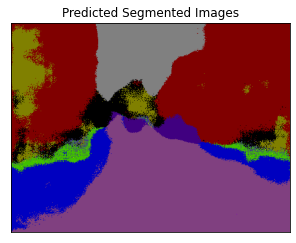

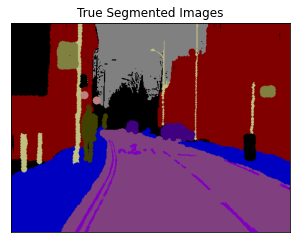

Epoch 6 has started......
Training the network......
Iteration:10 	 Loss:1.11276
Iteration:20 	 Loss:1.05651
Iteration:30 	 Loss:1.03788
Iteration:40 	 Loss:1.05684
Iteration:50 	 Loss:1.04624
Iteration:60 	 Loss:1.03366
Iteration:70 	 Loss:1.04439
Iteration:80 	 Loss:1.03754
Iteration:90 	 Loss:1.03454
Iteration:100 	 Loss:1.04061
Iteration:110 	 Loss:1.03794
Iteration:120 	 Loss:1.03707
Iteration:130 	 Loss:1.03767
Iteration:140 	 Loss:1.04204
Testing the network......
At the end of epoch 6 the average train loss is: 1.04204
At the end of epoch 6 the average test loss is: 0.99865


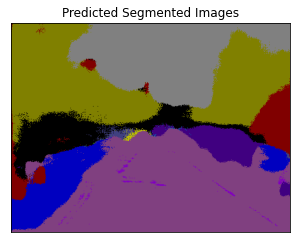

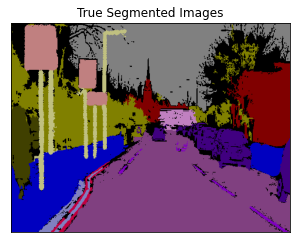

Epoch 7 has started......
Training the network......
Iteration:10 	 Loss:1.02682
Iteration:20 	 Loss:0.98713
Iteration:30 	 Loss:0.99548
Iteration:40 	 Loss:1.00931
Iteration:50 	 Loss:0.98807
Iteration:60 	 Loss:0.97840
Iteration:70 	 Loss:0.99065
Iteration:80 	 Loss:0.99797
Iteration:90 	 Loss:0.98631
Iteration:100 	 Loss:0.99392
Iteration:110 	 Loss:0.99820
Iteration:120 	 Loss:1.00645
Iteration:130 	 Loss:1.00154
Iteration:140 	 Loss:0.99762
Testing the network......
At the end of epoch 7 the average train loss is: 0.99762
At the end of epoch 7 the average test loss is: 0.97508


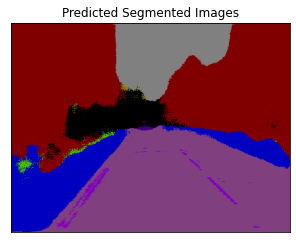

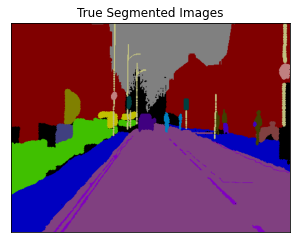

Epoch 8 has started......
Training the network......
Iteration:10 	 Loss:0.99467
Iteration:20 	 Loss:1.00064
Iteration:30 	 Loss:0.99199
Iteration:40 	 Loss:1.00164
Iteration:50 	 Loss:0.97903
Iteration:60 	 Loss:0.98238
Iteration:70 	 Loss:0.97550
Iteration:80 	 Loss:0.96166
Iteration:90 	 Loss:0.96725
Iteration:100 	 Loss:0.96692
Iteration:110 	 Loss:0.96265
Iteration:120 	 Loss:0.95854
Iteration:130 	 Loss:0.94760
Iteration:140 	 Loss:0.94679
Testing the network......
At the end of epoch 8 the average train loss is: 0.94679
At the end of epoch 8 the average test loss is: 0.91019


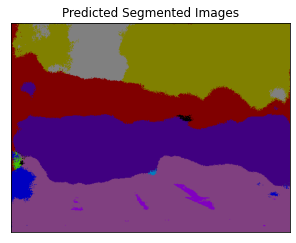

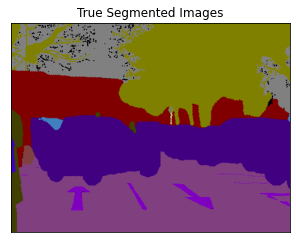

Epoch 9 has started......
Training the network......
Iteration:10 	 Loss:0.88097
Iteration:20 	 Loss:0.86655
Iteration:30 	 Loss:0.85343
Iteration:40 	 Loss:0.85927
Iteration:50 	 Loss:0.86518
Iteration:60 	 Loss:0.86989
Iteration:70 	 Loss:0.87757
Iteration:80 	 Loss:0.88030
Iteration:90 	 Loss:0.87028
Iteration:100 	 Loss:0.87575
Iteration:110 	 Loss:0.88138
Iteration:120 	 Loss:0.88773
Iteration:130 	 Loss:0.89580
Iteration:140 	 Loss:0.89463
Testing the network......
At the end of epoch 9 the average train loss is: 0.89463
At the end of epoch 9 the average test loss is: 0.92391


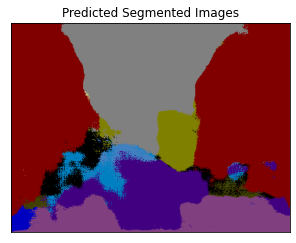

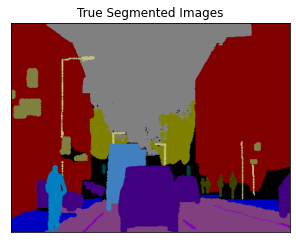

Epoch 10 has started......
Training the network......
Iteration:10 	 Loss:0.79897
Iteration:20 	 Loss:0.81136
Iteration:30 	 Loss:0.79962
Iteration:40 	 Loss:0.81080
Iteration:50 	 Loss:0.81410
Iteration:60 	 Loss:0.83685
Iteration:70 	 Loss:0.83199
Iteration:80 	 Loss:0.84692
Iteration:90 	 Loss:0.85286
Iteration:100 	 Loss:0.85406
Iteration:110 	 Loss:0.85495
Iteration:120 	 Loss:0.86108
Iteration:130 	 Loss:0.85837
Iteration:140 	 Loss:0.85636
Testing the network......
At the end of epoch 10 the average train loss is: 0.85636
At the end of epoch 10 the average test loss is: 0.85788


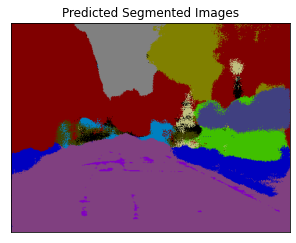

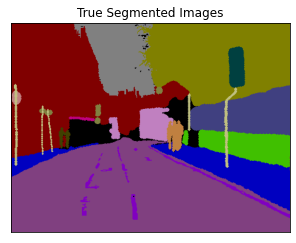

Epoch 11 has started......
Training the network......
Iteration:10 	 Loss:0.88231
Iteration:20 	 Loss:0.92354
Iteration:30 	 Loss:0.91341
Iteration:40 	 Loss:0.87904
Iteration:50 	 Loss:0.85546
Iteration:60 	 Loss:0.84541
Iteration:70 	 Loss:0.84159
Iteration:80 	 Loss:0.84836
Iteration:90 	 Loss:0.84647
Iteration:100 	 Loss:0.83746
Iteration:110 	 Loss:0.83692
Iteration:120 	 Loss:0.83866
Iteration:130 	 Loss:0.83802
Iteration:140 	 Loss:0.83458
Testing the network......
At the end of epoch 11 the average train loss is: 0.83458
At the end of epoch 11 the average test loss is: 0.81564


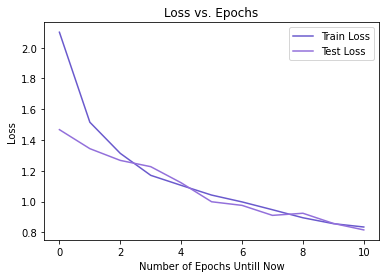

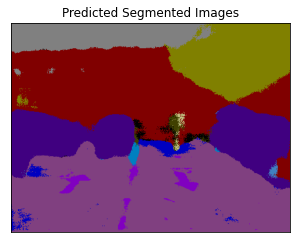

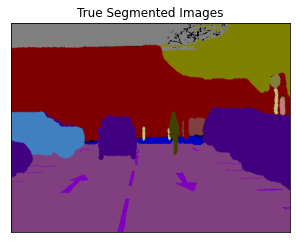

Epoch 12 has started......
Training the network......
Iteration:10 	 Loss:0.70530
Iteration:20 	 Loss:0.76949
Iteration:30 	 Loss:0.79797
Iteration:40 	 Loss:0.80827
Iteration:50 	 Loss:0.81892
Iteration:60 	 Loss:0.82098
Iteration:70 	 Loss:0.82556
Iteration:80 	 Loss:0.81613
Iteration:90 	 Loss:0.80922
Iteration:100 	 Loss:0.81023
Iteration:110 	 Loss:0.80998
Iteration:120 	 Loss:0.80855
Iteration:130 	 Loss:0.80957
Iteration:140 	 Loss:0.80678
Testing the network......
At the end of epoch 12 the average train loss is: 0.80678
At the end of epoch 12 the average test loss is: 0.84735


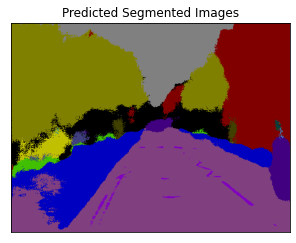

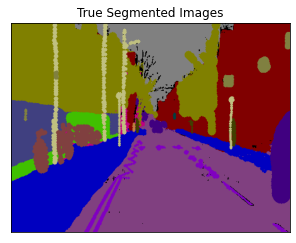

Epoch 13 has started......
Training the network......
Iteration:10 	 Loss:0.76933
Iteration:20 	 Loss:0.81257
Iteration:30 	 Loss:0.81698
Iteration:40 	 Loss:0.82478
Iteration:50 	 Loss:0.84086
Iteration:60 	 Loss:0.83630
Iteration:70 	 Loss:0.84424
Iteration:80 	 Loss:0.84181
Iteration:90 	 Loss:0.83928
Iteration:100 	 Loss:0.82865
Iteration:110 	 Loss:0.82257
Iteration:120 	 Loss:0.81883
Iteration:130 	 Loss:0.81305
Iteration:140 	 Loss:0.80785
Testing the network......
At the end of epoch 13 the average train loss is: 0.80785
At the end of epoch 13 the average test loss is: 0.76972


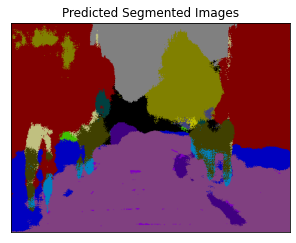

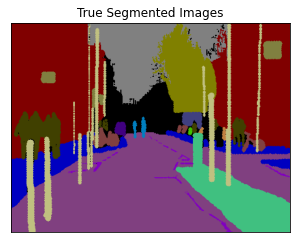

Epoch 14 has started......
Training the network......
Iteration:10 	 Loss:0.80981
Iteration:20 	 Loss:0.75383
Iteration:30 	 Loss:0.74799
Iteration:40 	 Loss:0.74989
Iteration:50 	 Loss:0.74509
Iteration:60 	 Loss:0.73594
Iteration:70 	 Loss:0.75297
Iteration:80 	 Loss:0.74311
Iteration:90 	 Loss:0.76076
Iteration:100 	 Loss:0.76534
Iteration:110 	 Loss:0.76440
Iteration:120 	 Loss:0.76300
Iteration:130 	 Loss:0.76579
Iteration:140 	 Loss:0.76395
Testing the network......
At the end of epoch 14 the average train loss is: 0.76395
At the end of epoch 14 the average test loss is: 0.75894


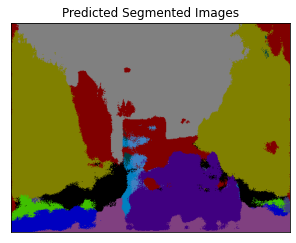

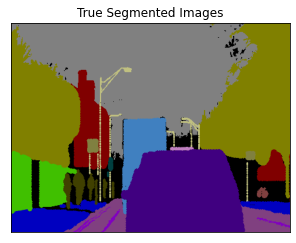

Epoch 15 has started......
Training the network......
Iteration:10 	 Loss:0.72652
Iteration:20 	 Loss:0.74177
Iteration:30 	 Loss:0.74119
Iteration:40 	 Loss:0.72478
Iteration:50 	 Loss:0.72146
Iteration:60 	 Loss:0.73251
Iteration:70 	 Loss:0.73344
Iteration:80 	 Loss:0.74223
Iteration:90 	 Loss:0.73668
Iteration:100 	 Loss:0.73901
Iteration:110 	 Loss:0.73817
Iteration:120 	 Loss:0.74165
Iteration:130 	 Loss:0.74244
Iteration:140 	 Loss:0.73899
Testing the network......
At the end of epoch 15 the average train loss is: 0.73899
At the end of epoch 15 the average test loss is: 0.73083


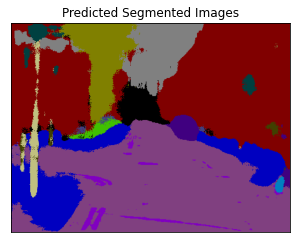

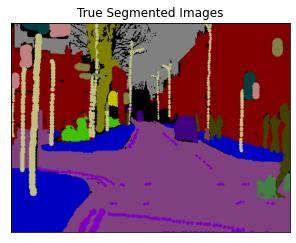

Epoch 16 has started......
Training the network......
Iteration:10 	 Loss:0.71396
Iteration:20 	 Loss:0.71459
Iteration:30 	 Loss:0.73532
Iteration:40 	 Loss:0.73488
Iteration:50 	 Loss:0.72992
Iteration:60 	 Loss:0.72929
Iteration:70 	 Loss:0.71903
Iteration:80 	 Loss:0.71519
Iteration:90 	 Loss:0.71018
Iteration:100 	 Loss:0.70868
Iteration:110 	 Loss:0.70920
Iteration:120 	 Loss:0.71304
Iteration:130 	 Loss:0.71915
Iteration:140 	 Loss:0.72280
Testing the network......
At the end of epoch 16 the average train loss is: 0.72280
At the end of epoch 16 the average test loss is: 0.73869


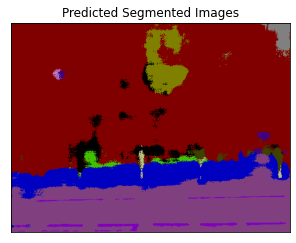

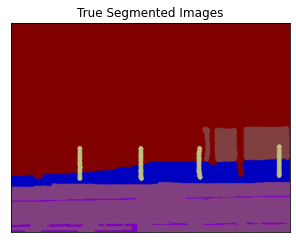

Epoch 17 has started......
Training the network......
Iteration:10 	 Loss:0.73692
Iteration:20 	 Loss:0.74883
Iteration:30 	 Loss:0.73523
Iteration:40 	 Loss:0.72418
Iteration:50 	 Loss:0.72297
Iteration:60 	 Loss:0.71231
Iteration:70 	 Loss:0.71433
Iteration:80 	 Loss:0.71453
Iteration:90 	 Loss:0.71865
Iteration:100 	 Loss:0.71224
Iteration:110 	 Loss:0.71098
Iteration:120 	 Loss:0.71364
Iteration:130 	 Loss:0.71396
Iteration:140 	 Loss:0.71196
Testing the network......
At the end of epoch 17 the average train loss is: 0.71196
At the end of epoch 17 the average test loss is: 0.72845


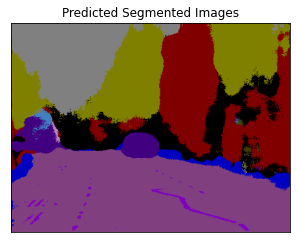

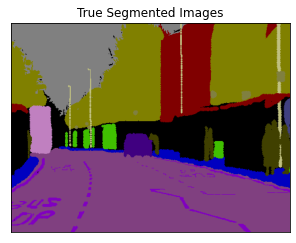

Epoch 18 has started......
Training the network......
Iteration:10 	 Loss:0.73530
Iteration:20 	 Loss:0.70150
Iteration:30 	 Loss:0.68882
Iteration:40 	 Loss:0.68569
Iteration:50 	 Loss:0.69300
Iteration:60 	 Loss:0.70634
Iteration:70 	 Loss:0.70760
Iteration:80 	 Loss:0.70242
Iteration:90 	 Loss:0.70270
Iteration:100 	 Loss:0.70653
Iteration:110 	 Loss:0.70886
Iteration:120 	 Loss:0.71564
Iteration:130 	 Loss:0.71229
Iteration:140 	 Loss:0.71397
Testing the network......
At the end of epoch 18 the average train loss is: 0.71397
At the end of epoch 18 the average test loss is: 0.72275


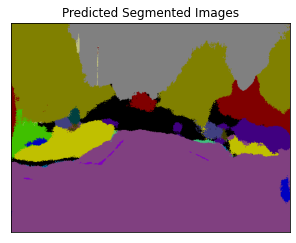

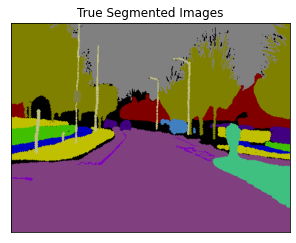

Epoch 19 has started......
Training the network......
Iteration:10 	 Loss:0.72228
Iteration:20 	 Loss:0.68909
Iteration:30 	 Loss:0.68909
Iteration:40 	 Loss:0.68292
Iteration:50 	 Loss:0.67575
Iteration:60 	 Loss:0.66799
Iteration:70 	 Loss:0.68867
Iteration:80 	 Loss:0.68802
Iteration:90 	 Loss:0.68981
Iteration:100 	 Loss:0.68437
Iteration:110 	 Loss:0.68172
Iteration:120 	 Loss:0.67757
Iteration:130 	 Loss:0.68222
Iteration:140 	 Loss:0.68479
Testing the network......
At the end of epoch 19 the average train loss is: 0.68479
At the end of epoch 19 the average test loss is: 0.68903


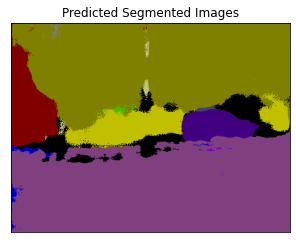

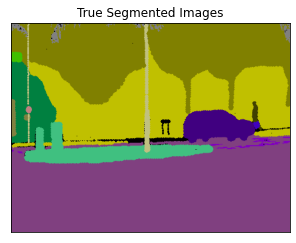

Epoch 20 has started......
Training the network......
Iteration:10 	 Loss:0.59692
Iteration:20 	 Loss:0.65877
Iteration:30 	 Loss:0.69209
Iteration:40 	 Loss:0.69898
Iteration:50 	 Loss:0.71196
Iteration:60 	 Loss:0.71811
Iteration:70 	 Loss:0.71222
Iteration:80 	 Loss:0.70780
Iteration:90 	 Loss:0.70456
Iteration:100 	 Loss:0.69762
Iteration:110 	 Loss:0.70154
Iteration:120 	 Loss:0.70263
Iteration:130 	 Loss:0.69856
Iteration:140 	 Loss:0.69878
Testing the network......
At the end of epoch 20 the average train loss is: 0.69878
At the end of epoch 20 the average test loss is: 0.73653


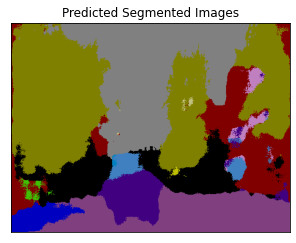

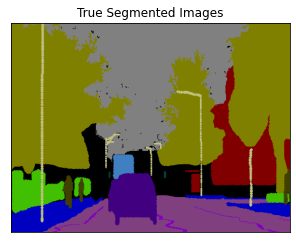

Epoch 21 has started......
Training the network......
Iteration:10 	 Loss:0.68429
Iteration:20 	 Loss:0.68967
Iteration:30 	 Loss:0.66557
Iteration:40 	 Loss:0.67421
Iteration:50 	 Loss:0.68667
Iteration:60 	 Loss:0.67302
Iteration:70 	 Loss:0.67736
Iteration:80 	 Loss:0.68020
Iteration:90 	 Loss:0.67396
Iteration:100 	 Loss:0.67089
Iteration:110 	 Loss:0.66846
Iteration:120 	 Loss:0.66977
Iteration:130 	 Loss:0.66809
Iteration:140 	 Loss:0.67003
Testing the network......
At the end of epoch 21 the average train loss is: 0.67003
At the end of epoch 21 the average test loss is: 0.71742


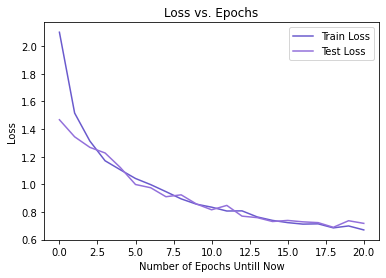

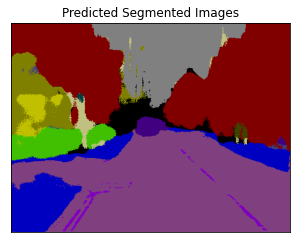

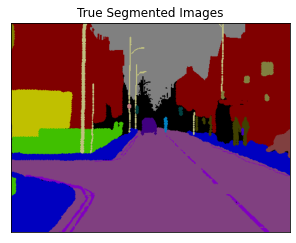

Epoch 22 has started......
Training the network......
Iteration:10 	 Loss:0.65378
Iteration:20 	 Loss:0.66619
Iteration:30 	 Loss:0.66266
Iteration:40 	 Loss:0.69282
Iteration:50 	 Loss:0.68882
Iteration:60 	 Loss:0.68618
Iteration:70 	 Loss:0.69839
Iteration:80 	 Loss:0.72194
Iteration:90 	 Loss:0.73053
Iteration:100 	 Loss:0.72192
Iteration:110 	 Loss:0.72328
Iteration:120 	 Loss:0.72397
Iteration:130 	 Loss:0.72526
Iteration:140 	 Loss:0.71869
Testing the network......
At the end of epoch 22 the average train loss is: 0.71869
At the end of epoch 22 the average test loss is: 0.73713


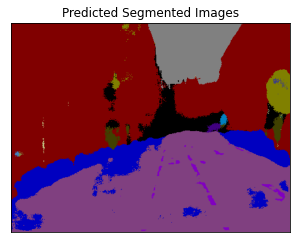

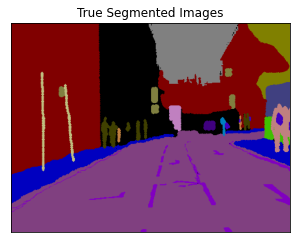

Epoch 23 has started......
Training the network......
Iteration:10 	 Loss:0.64834
Iteration:20 	 Loss:0.59753
Iteration:30 	 Loss:0.61036
Iteration:40 	 Loss:0.61563
Iteration:50 	 Loss:0.60995
Iteration:60 	 Loss:0.62086
Iteration:70 	 Loss:0.62816
Iteration:80 	 Loss:0.62319
Iteration:90 	 Loss:0.62594
Iteration:100 	 Loss:0.63067
Iteration:110 	 Loss:0.63413
Iteration:120 	 Loss:0.63997
Iteration:130 	 Loss:0.64197
Iteration:140 	 Loss:0.64477
Testing the network......
At the end of epoch 23 the average train loss is: 0.64477
At the end of epoch 23 the average test loss is: 0.75273


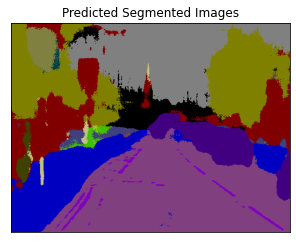

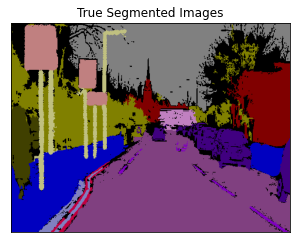

Epoch 24 has started......
Training the network......
Iteration:10 	 Loss:0.64079
Iteration:20 	 Loss:0.68416
Iteration:30 	 Loss:0.66930
Iteration:40 	 Loss:0.66047
Iteration:50 	 Loss:0.66867
Iteration:60 	 Loss:0.66291
Iteration:70 	 Loss:0.65648
Iteration:80 	 Loss:0.64778
Iteration:90 	 Loss:0.64825
Iteration:100 	 Loss:0.64156
Iteration:110 	 Loss:0.64077
Iteration:120 	 Loss:0.64334
Iteration:130 	 Loss:0.64216
Iteration:140 	 Loss:0.64379
Testing the network......
At the end of epoch 24 the average train loss is: 0.64379
At the end of epoch 24 the average test loss is: 0.64544


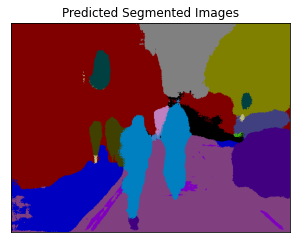

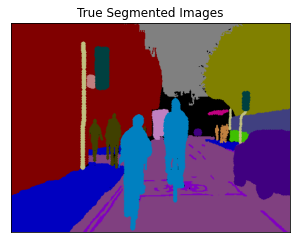

Epoch 25 has started......
Training the network......
Iteration:10 	 Loss:0.64193
Iteration:20 	 Loss:0.60656
Iteration:30 	 Loss:0.60688
Iteration:40 	 Loss:0.61065
Iteration:50 	 Loss:0.63244
Iteration:60 	 Loss:0.64717
Iteration:70 	 Loss:0.64531
Iteration:80 	 Loss:0.66495
Iteration:90 	 Loss:0.67460
Iteration:100 	 Loss:0.67654
Iteration:110 	 Loss:0.67567
Iteration:120 	 Loss:0.66932
Iteration:130 	 Loss:0.66612
Iteration:140 	 Loss:0.66037
Testing the network......
At the end of epoch 25 the average train loss is: 0.66037
At the end of epoch 25 the average test loss is: 0.69923


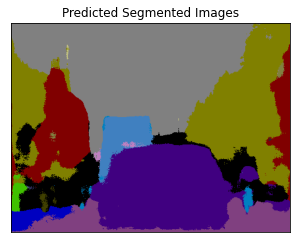

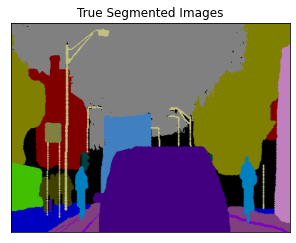

Epoch 26 has started......
Training the network......
Iteration:10 	 Loss:0.61499
Iteration:20 	 Loss:0.59749
Iteration:30 	 Loss:0.60678
Iteration:40 	 Loss:0.60323
Iteration:50 	 Loss:0.60568
Iteration:60 	 Loss:0.59523
Iteration:70 	 Loss:0.59799
Iteration:80 	 Loss:0.60111
Iteration:90 	 Loss:0.60698
Iteration:100 	 Loss:0.61032
Iteration:110 	 Loss:0.61334
Iteration:120 	 Loss:0.61079
Iteration:130 	 Loss:0.61276
Iteration:140 	 Loss:0.61105
Testing the network......
At the end of epoch 26 the average train loss is: 0.61105
At the end of epoch 26 the average test loss is: 0.65254


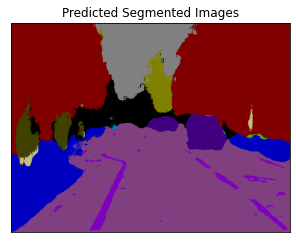

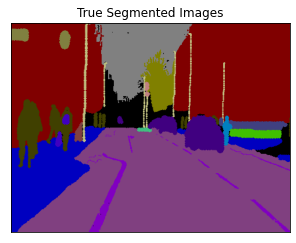

Epoch 27 has started......
Training the network......
Iteration:10 	 Loss:0.57389
Iteration:20 	 Loss:0.60483
Iteration:30 	 Loss:0.59653
Iteration:40 	 Loss:0.60829
Iteration:50 	 Loss:0.60244
Iteration:60 	 Loss:0.60177
Iteration:70 	 Loss:0.61086
Iteration:80 	 Loss:0.61391
Iteration:90 	 Loss:0.61142
Iteration:100 	 Loss:0.61030
Iteration:110 	 Loss:0.61032
Iteration:120 	 Loss:0.60804
Iteration:130 	 Loss:0.60894
Iteration:140 	 Loss:0.60824
Testing the network......
At the end of epoch 27 the average train loss is: 0.60824
At the end of epoch 27 the average test loss is: 0.66619


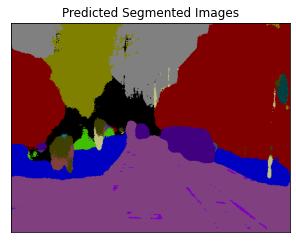

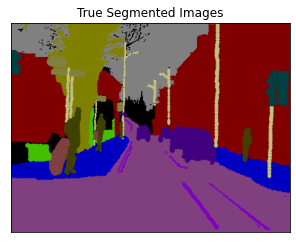

Epoch 28 has started......
Training the network......
Iteration:10 	 Loss:0.58828
Iteration:20 	 Loss:0.59937
Iteration:30 	 Loss:0.59465
Iteration:40 	 Loss:0.59553
Iteration:50 	 Loss:0.59845
Iteration:60 	 Loss:0.59730
Iteration:70 	 Loss:0.60346
Iteration:80 	 Loss:0.60841
Iteration:90 	 Loss:0.61336
Iteration:100 	 Loss:0.61349
Iteration:110 	 Loss:0.61528
Iteration:120 	 Loss:0.61486
Iteration:130 	 Loss:0.60795
Iteration:140 	 Loss:0.60122
Testing the network......
At the end of epoch 28 the average train loss is: 0.60122
At the end of epoch 28 the average test loss is: 0.65757


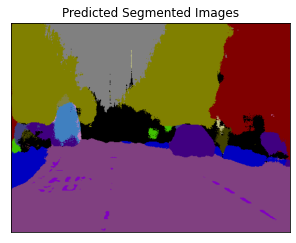

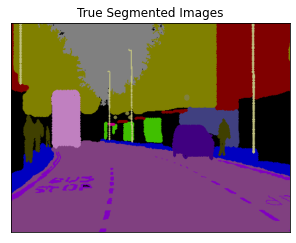

Epoch 29 has started......
Training the network......
Iteration:10 	 Loss:0.55568
Iteration:20 	 Loss:0.54107
Iteration:30 	 Loss:0.53724
Iteration:40 	 Loss:0.55641
Iteration:50 	 Loss:0.55009
Iteration:60 	 Loss:0.54810
Iteration:70 	 Loss:0.55686
Iteration:80 	 Loss:0.55417
Iteration:90 	 Loss:0.56056
Iteration:100 	 Loss:0.57152
Iteration:110 	 Loss:0.57747
Iteration:120 	 Loss:0.58262
Iteration:130 	 Loss:0.58323
Iteration:140 	 Loss:0.58865
Testing the network......
At the end of epoch 29 the average train loss is: 0.58865
At the end of epoch 29 the average test loss is: 0.62096


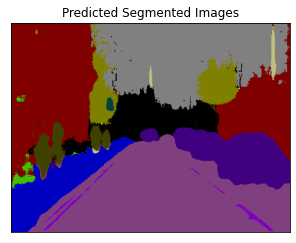

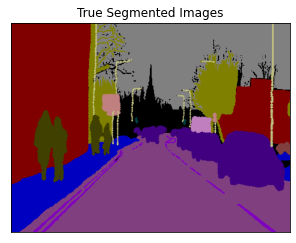

Epoch 30 has started......
Training the network......
Iteration:10 	 Loss:0.63622
Iteration:20 	 Loss:0.59609
Iteration:30 	 Loss:0.61359
Iteration:40 	 Loss:0.62379
Iteration:50 	 Loss:0.60773
Iteration:60 	 Loss:0.60396
Iteration:70 	 Loss:0.59428
Iteration:80 	 Loss:0.58697
Iteration:90 	 Loss:0.58386
Iteration:100 	 Loss:0.58642
Iteration:110 	 Loss:0.59269
Iteration:120 	 Loss:0.59084
Iteration:130 	 Loss:0.60469
Iteration:140 	 Loss:0.60986
Testing the network......
At the end of epoch 30 the average train loss is: 0.60986
At the end of epoch 30 the average test loss is: 0.78991


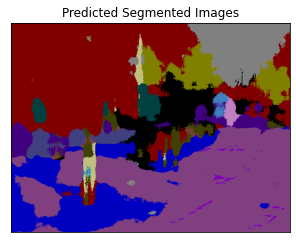

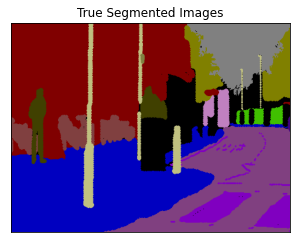

Epoch 31 has started......
Training the network......
Iteration:10 	 Loss:0.56027
Iteration:20 	 Loss:0.59575
Iteration:30 	 Loss:0.61141
Iteration:40 	 Loss:0.61503
Iteration:50 	 Loss:0.61259
Iteration:60 	 Loss:0.61750
Iteration:70 	 Loss:0.62095
Iteration:80 	 Loss:0.61780
Iteration:90 	 Loss:0.62505
Iteration:100 	 Loss:0.62278
Iteration:110 	 Loss:0.61728
Iteration:120 	 Loss:0.61231
Iteration:130 	 Loss:0.60913
Iteration:140 	 Loss:0.61120
Testing the network......
At the end of epoch 31 the average train loss is: 0.61120
At the end of epoch 31 the average test loss is: 0.73485


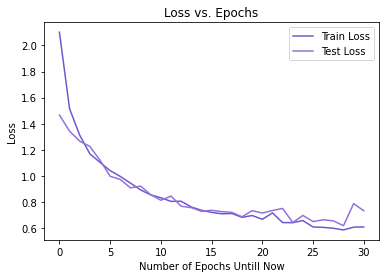

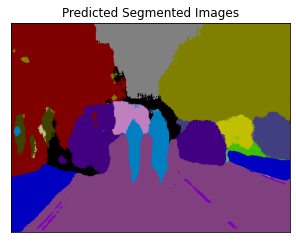

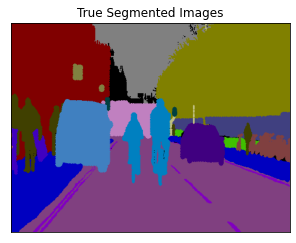

Epoch 32 has started......
Training the network......
Iteration:10 	 Loss:0.60067
Iteration:20 	 Loss:0.60033
Iteration:30 	 Loss:0.60636
Iteration:40 	 Loss:0.60484
Iteration:50 	 Loss:0.59732
Iteration:60 	 Loss:0.59275
Iteration:70 	 Loss:0.58439
Iteration:80 	 Loss:0.58219
Iteration:90 	 Loss:0.57743
Iteration:100 	 Loss:0.58199
Iteration:110 	 Loss:0.58242
Iteration:120 	 Loss:0.57891
Iteration:130 	 Loss:0.57841
Iteration:140 	 Loss:0.57823
Testing the network......
At the end of epoch 32 the average train loss is: 0.57823
At the end of epoch 32 the average test loss is: 0.59236


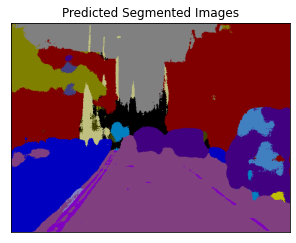

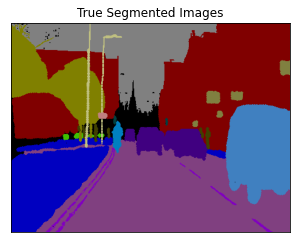

Epoch 33 has started......
Training the network......
Iteration:10 	 Loss:0.54921
Iteration:20 	 Loss:0.58556
Iteration:30 	 Loss:0.58067
Iteration:40 	 Loss:0.57056
Iteration:50 	 Loss:0.55663
Iteration:60 	 Loss:0.56495
Iteration:70 	 Loss:0.56577
Iteration:80 	 Loss:0.56393
Iteration:90 	 Loss:0.56328
Iteration:100 	 Loss:0.57114
Iteration:110 	 Loss:0.56663
Iteration:120 	 Loss:0.56616
Iteration:130 	 Loss:0.56220
Iteration:140 	 Loss:0.55840
Testing the network......
At the end of epoch 33 the average train loss is: 0.55840
At the end of epoch 33 the average test loss is: 0.63593


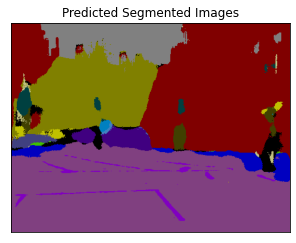

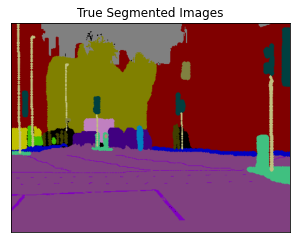

Epoch 34 has started......
Training the network......
Iteration:10 	 Loss:0.50918
Iteration:20 	 Loss:0.50253
Iteration:30 	 Loss:0.49281
Iteration:40 	 Loss:0.51302
Iteration:50 	 Loss:0.51252
Iteration:60 	 Loss:0.51722
Iteration:70 	 Loss:0.52075
Iteration:80 	 Loss:0.52847
Iteration:90 	 Loss:0.53437
Iteration:100 	 Loss:0.53881
Iteration:110 	 Loss:0.53814
Iteration:120 	 Loss:0.54120
Iteration:130 	 Loss:0.54397
Iteration:140 	 Loss:0.54492
Testing the network......
At the end of epoch 34 the average train loss is: 0.54492
At the end of epoch 34 the average test loss is: 0.60852


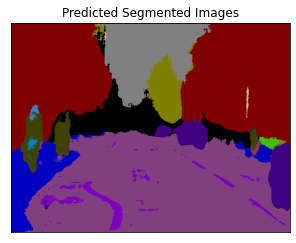

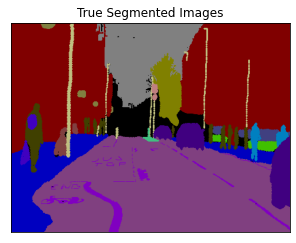

Epoch 35 has started......
Training the network......
Iteration:10 	 Loss:0.53853
Iteration:20 	 Loss:0.53011
Iteration:30 	 Loss:0.53062
Iteration:40 	 Loss:0.54014
Iteration:50 	 Loss:0.54121
Iteration:60 	 Loss:0.54363
Iteration:70 	 Loss:0.54761
Iteration:80 	 Loss:0.54562
Iteration:90 	 Loss:0.54217
Iteration:100 	 Loss:0.53630
Iteration:110 	 Loss:0.53357
Iteration:120 	 Loss:0.53610
Iteration:130 	 Loss:0.53920
Iteration:140 	 Loss:0.54409
Testing the network......
At the end of epoch 35 the average train loss is: 0.54409
At the end of epoch 35 the average test loss is: 0.68129


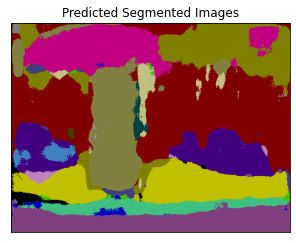

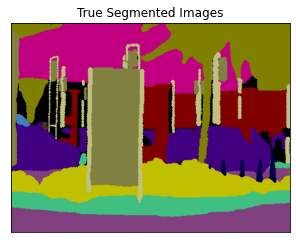

Epoch 36 has started......
Training the network......
Iteration:10 	 Loss:0.58964
Iteration:20 	 Loss:0.57577
Iteration:30 	 Loss:0.57224
Iteration:40 	 Loss:0.56473
Iteration:50 	 Loss:0.55807
Iteration:60 	 Loss:0.55262
Iteration:70 	 Loss:0.54890
Iteration:80 	 Loss:0.55216
Iteration:90 	 Loss:0.55547
Iteration:100 	 Loss:0.56028
Iteration:110 	 Loss:0.56245
Iteration:120 	 Loss:0.55647
Iteration:130 	 Loss:0.56112
Iteration:140 	 Loss:0.55855
Testing the network......
At the end of epoch 36 the average train loss is: 0.55855
At the end of epoch 36 the average test loss is: 0.66379


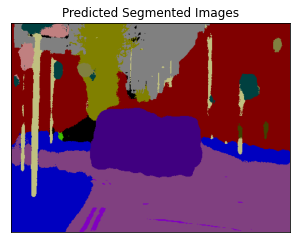

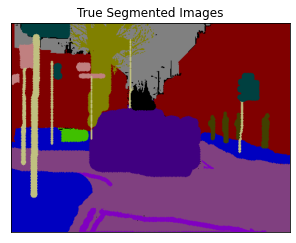

Epoch 37 has started......
Training the network......
Iteration:10 	 Loss:0.57378
Iteration:20 	 Loss:0.56216
Iteration:30 	 Loss:0.54259
Iteration:40 	 Loss:0.53682
Iteration:50 	 Loss:0.53369
Iteration:60 	 Loss:0.52825
Iteration:70 	 Loss:0.53343
Iteration:80 	 Loss:0.53704
Iteration:90 	 Loss:0.53421
Iteration:100 	 Loss:0.53812
Iteration:110 	 Loss:0.53863
Iteration:120 	 Loss:0.53683
Iteration:130 	 Loss:0.53833
Iteration:140 	 Loss:0.53851
Testing the network......
At the end of epoch 37 the average train loss is: 0.53851
At the end of epoch 37 the average test loss is: 0.63313


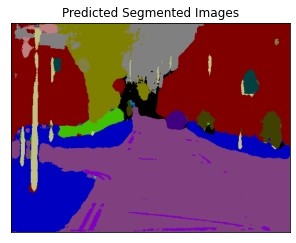

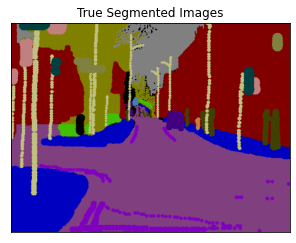

Epoch 38 has started......
Training the network......
Iteration:10 	 Loss:0.49727
Iteration:20 	 Loss:0.50999
Iteration:30 	 Loss:0.49950
Iteration:40 	 Loss:0.50910
Iteration:50 	 Loss:0.51459
Iteration:60 	 Loss:0.52152
Iteration:70 	 Loss:0.51732
Iteration:80 	 Loss:0.52794
Iteration:90 	 Loss:0.53242
Iteration:100 	 Loss:0.52961
Iteration:110 	 Loss:0.52079
Iteration:120 	 Loss:0.52169
Iteration:130 	 Loss:0.52479
Iteration:140 	 Loss:0.52793
Testing the network......
At the end of epoch 38 the average train loss is: 0.52793
At the end of epoch 38 the average test loss is: 0.65353


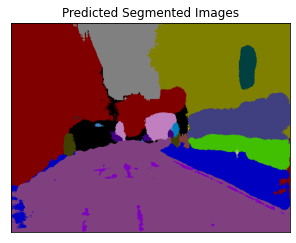

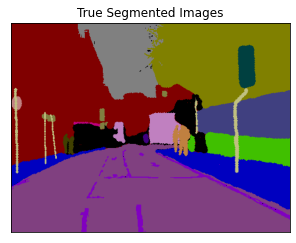

Epoch 39 has started......
Training the network......
Iteration:10 	 Loss:0.55565
Iteration:20 	 Loss:0.52792
Iteration:30 	 Loss:0.54459
Iteration:40 	 Loss:0.54001
Iteration:50 	 Loss:0.52976
Iteration:60 	 Loss:0.52711
Iteration:70 	 Loss:0.52471
Iteration:80 	 Loss:0.51607
Iteration:90 	 Loss:0.52118
Iteration:100 	 Loss:0.51746
Iteration:110 	 Loss:0.51860
Iteration:120 	 Loss:0.52363
Iteration:130 	 Loss:0.52123
Iteration:140 	 Loss:0.52195
Testing the network......
At the end of epoch 39 the average train loss is: 0.52195
At the end of epoch 39 the average test loss is: 0.56738


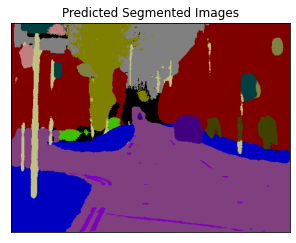

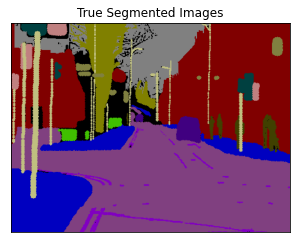

Epoch 40 has started......
Training the network......
Iteration:10 	 Loss:0.44535
Iteration:20 	 Loss:0.46518
Iteration:30 	 Loss:0.47462
Iteration:40 	 Loss:0.48207
Iteration:50 	 Loss:0.48642
Iteration:60 	 Loss:0.49492
Iteration:70 	 Loss:0.49800
Iteration:80 	 Loss:0.50704
Iteration:90 	 Loss:0.50842
Iteration:100 	 Loss:0.51185
Iteration:110 	 Loss:0.51334
Iteration:120 	 Loss:0.51521
Iteration:130 	 Loss:0.51261
Iteration:140 	 Loss:0.51396
Testing the network......
At the end of epoch 40 the average train loss is: 0.51396
At the end of epoch 40 the average test loss is: 0.66171


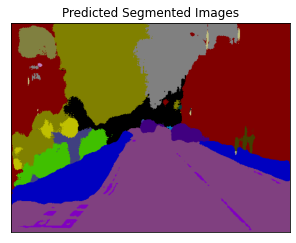

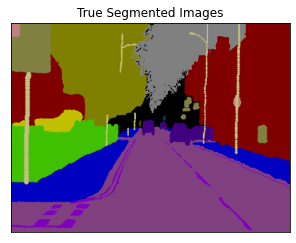

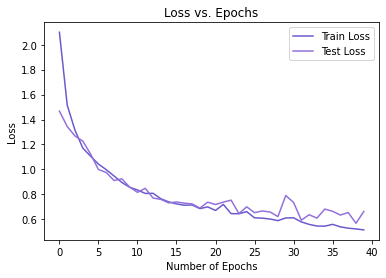

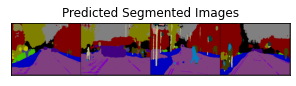

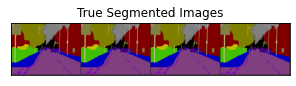

In [ ]:
train(mySegNet, criterion, optimizer, batchTrainDataset, batchTestDataset, 40)

####  <font color=SlateBlue>Plotting One Instance of Test and Predicted Labels</font> ####

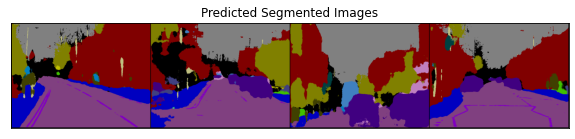

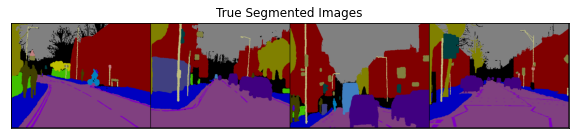

In [ ]:
def plotImages(net, batchTestDataset):
  with torch.no_grad():
    for testData, testLabels in batchTestDataset:
      if torch.cuda.is_available():
        testData = Variable(testData).cuda()
        testLabels = Variable(testLabels).cuda()
      else:
        testData = Variable(testData)
        testLabels = Variable(testLabels)

      allTestPredLabels = net(testData)

      testPredLabels = allTestPredLabels.max(dim=1)[1].data.cpu()
      tensor = torch.ones((testData.shape), dtype=torch.short)
      newLabels = [(indextoRGB(testPredLabels[i,:,:], RGBRef)).numpy() for i in range(testData.shape[0])]
      showImgs(tensor.new_tensor(newLabels), 100, 'Predicted Segmented Images')

      labels = testLabels.data.cpu()
      tensor = torch.ones((labels.shape), dtype=torch.short)
      newLabels = [(indextoRGB(labels[i,:,:], RGBRef)).numpy() for i in range(testData.shape[0])]
      showImgs(tensor.new_tensor(newLabels), 100, 'True Segmented Images')

      break


plotImages(mySegNet, batchTestDataset)

